# ETAPA 1 - Análise Descritiva da Exposição de IA Generativa com ILO Index e PNADc
## ANÁLISE DOS DADOS 


**Dissertação:** Inteligência Artificial Generativa e o Mercado de Trabalho Brasileiro: Uma Análise de Exposição Ocupacional e seus Efeitos Distributivos.

**Aluno:** Manoel Brasil Orlandi

### Contextualização

A rápida difusão de modelos de IA generativa (LLMs, geradores de imagem/código) levanta questões centrais sobre seus impactos no mercado de trabalho. Para mensurar esse potencial de impacto, a  Organização Internacional do Trabalho (OIT) criou índice de exposição ocupacional à IA generativa, publicado como *Working Paper* 140 (WP140). O índice atribui scores de exposição a cada ocupação da classificação ISCO-08, com base na avaliação de suas tarefas constituintes por modelos de linguagem e validação humana.

Este notebook faz a análise e descrição populacional usando como base os dados `pnad_ilo_merged.csv` que junta os microdados da **PNAD Contínua** (Pesquisa Nacional por Amostra de Domicílios Contínua, IBGE, 3º trimestre de 2025) ao **índice de exposição à IA generativa da OIT* e foram preparados no notebook `etapa_1a_preparacao_dados_ilo_pnadc.ipynb`. 

> **Nota:** O salário mínimo vigente de R$ 1.518 segue o Decreto nº 12.342/2025.
> Os dados da PNADc referem-se ao 3º trimestre de 2025 e são combinados ao
> índice de exposição ILO WP140 (versão 2025). Como o índice foi construído
> para a classificação ISCO-08, utilizou-se um crosswalk COD→ISCO-08 que
> introduz potencial erro de medida (ver Limitações, Seção 9).

### Objetivo da Análise

**Perfil da exposição**: Distribuição da população por quintil/decil de exposição; média ponderada de exposure_score por grupo.

**Desigualdade e renda**: Rendimento médio (e mediano) ponderado por quintil de exposição; razão renda Q5/Q1 de exposição.

**Gênero e raça**: % de mulheres e de negros por quintil de exposição; exposição média por sexo e raça	

**Formalidade**: % formal por quintil de exposição; exposição média no formal vs informal	

**Setor e ocupação**: Exposição média por setor_agregado e por grande_grupo; concentração em setores críticos IA.

**Região**: Exposição média por região; população em alta exposição por UF/região.

**Idade e instrução**: Exposição média por faixa etária e nível de instrução.

**Augmentation vs. Automação**: Comparação entre trabalhadores em gradientes de complementaridade (G1-G2) e transformação (G3-G4).

### Referências principais

- Gmyrek, P., Berg, J. & Cappelli, D. (2025). *Generative AI and Jobs: An updated global assessment of potential effects on job quantity and quality*. ILO Working Paper 140.
- IBGE. *Pesquisa Nacional por Amostra de Domicílios Contínua* (PNADc), 3º trimestre de 2025.

> **Conexão com WP140:** O índice de exposição da OIT segue a abordagem
> task-based (Autor, 2015; Acemoglu & Restrepo, 2019), onde cada ocupação
> é decomposta em tarefas e cada tarefa é avaliada quanto à capacidade de
> modelos de IA generativa de realizá-la. O WP140 estende trabalhos
> anteriores (Felten et al., 2021; Eloundou et al., 2023) ao incorporar
> validação humana e distinguir entre potencial de automação e de
> complementaridade (augmentation).

### 1. Configuração do ambiente
Definir caminhos, importar bibliotecas e configurar logs. 

In [64]:
# Instalar dependencias no kernel atual (executar apenas uma vez)
%pip install pandas numpy pyarrow openpyxl statsmodels scipy matplotlib seaborn --quiet


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
# Etapa 1b.1 - Analise de Dados - Configuracao do ambiente

import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import gaussian_kde, ks_2samp, linregress
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
import statsmodels.formula.api as smf
import statsmodels.api as sm

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', '{:.3f}'.format)

# ---------------------------------------------------------------------------
# Estilo visual
# ---------------------------------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 100,
})

# ---------------------------------------------------------------------------
# Caminhos
# ---------------------------------------------------------------------------
DATA_OUTPUT = Path("data/output")
DATA_INPUT  = Path("data/input")

# ---------------------------------------------------------------------------
# Parametros
# ---------------------------------------------------------------------------
SALARIO_MINIMO = 1518
PNAD_ANO       = 2025
PNAD_TRIMESTRE = 3

# ---------------------------------------------------------------------------
# Mapeamentos e constantes (replicados de settings.py)
# ---------------------------------------------------------------------------
REGIAO_MAP = {
    'RO': 'Norte', 'AC': 'Norte', 'AM': 'Norte', 'RR': 'Norte',
    'PA': 'Norte', 'AP': 'Norte', 'TO': 'Norte',
    'MA': 'Nordeste', 'PI': 'Nordeste', 'CE': 'Nordeste', 'RN': 'Nordeste',
    'PB': 'Nordeste', 'PE': 'Nordeste', 'AL': 'Nordeste', 'SE': 'Nordeste', 'BA': 'Nordeste',
    'MG': 'Sudeste', 'ES': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'SC': 'Sul', 'RS': 'Sul',
    'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'DF': 'Centro-Oeste',
}

GRANDES_GRUPOS = {
    '1': 'Dirigentes e gerentes',
    '2': 'Profissionais das ciencias',
    '3': 'Tecnicos nivel medio',
    '4': 'Apoio administrativo',
    '5': 'Servicos e vendedores',
    '6': 'Agropecuaria qualificada',
    '7': 'Industria qualificada',
    '8': 'Operadores de maquinas',
    '9': 'Ocupacoes elementares',
}

GRADIENT_ORDER = [
    'Not Exposed', 'Minimal Exposure',
    'Exposed: Gradient 1', 'Exposed: Gradient 2',
    'Exposed: Gradient 3', 'Exposed: Gradient 4',
]

GRADIENT_COLORS = {
    'Not Exposed':          '#2ca02c',
    'Minimal Exposure':     '#98df8a',
    'Exposed: Gradient 1':  '#aec7e8',
    'Exposed: Gradient 2':  '#ffbb78',
    'Exposed: Gradient 3':  '#ff7f0e',
    'Exposed: Gradient 4':  '#d62728',
    'Sem classificacao':    '#d9d9d9',
}

GRADIENT_LABELS_PT = {
    'Not Exposed':          'Nao Exposto',
    'Minimal Exposure':     'Exposicao Minima',
    'Exposed: Gradient 1':  'Gradiente 1 (Aumento)',
    'Exposed: Gradient 2':  'Gradiente 2',
    'Exposed: Gradient 3':  'Gradiente 3',
    'Exposed: Gradient 4':  'Gradiente 4 (Automacao)',
}

HIGH_EXPOSURE_GRADIENTS = ['Exposed: Gradient 3', 'Exposed: Gradient 4']
QUINTIL_ORDER = ['Q1 (Baixa)', 'Q2', 'Q3', 'Q4', 'Q5 (Alta)']
DECIL_ORDER = [f'D{i}' for i in range(1, 11)]

NIVEL_INSTRUCAO_ORDER = [
    'Sem instrucao', 'Fundamental incompleto', 'Fundamental completo',
    'Medio incompleto', 'Medio completo', 'Superior incompleto', 'Superior completo',
]

SETORES_CRITICOS_IA = [
    'Informacao e Comunicacao', 'Financas e Seguros', 'Servicos Profissionais',
]

# ---------------------------------------------------------------------------
# Funcoes utilitarias - estatisticas ponderadas
# ---------------------------------------------------------------------------
def weighted_mean(values, weights):
    """Media ponderada (ignora NaN)."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() == 0:
        return np.nan
    return np.average(values[mask], weights=weights[mask])

def weighted_std(values, weights):
    """Desvio-padrao ponderado (ignora NaN)."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() == 0:
        return np.nan
    avg = np.average(values[mask], weights=weights[mask])
    variance = np.average((values[mask] - avg) ** 2, weights=weights[mask])
    return np.sqrt(variance)

def weighted_quantile(values, weights, quantile):
    """Quantil ponderado por pesos amostrais (ignora NaN)."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() == 0:
        return np.nan
    sorted_idx = np.argsort(values[mask])
    sorted_values = values[mask].iloc[sorted_idx]
    sorted_weights = weights[mask].iloc[sorted_idx]
    cumsum = np.cumsum(sorted_weights)
    cutoff = quantile * cumsum.iloc[-1]
    return sorted_values.iloc[np.searchsorted(cumsum, cutoff)]

def gini_coefficient(values, weights):
    """Coeficiente de Gini ponderado."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() < 2:
        return np.nan
    x = np.array(values[mask])
    w = np.array(weights[mask])
    sorted_idx = np.argsort(x)
    sorted_x = x[sorted_idx]
    sorted_w = w[sorted_idx]
    cumsum_w = np.cumsum(sorted_w)
    cumsum_wx = np.cumsum(sorted_w * sorted_x)
    total_w = cumsum_w[-1]
    total_wx = cumsum_wx[-1]
    B = np.sum(cumsum_wx[:-1] * sorted_w[1:]) / (total_w * total_wx)
    return 1 - 2 * B

def weighted_ci(values, weights, alpha=0.05):
    """Retorna (media, IC_inferior, IC_superior) usando DescrStatsW."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() < 2:
        return np.nan, np.nan, np.nan
    d = DescrStatsW(data=np.array(values[mask]), weights=np.array(weights[mask]))
    ci = d.tconfint_mean(alpha=alpha)
    return d.mean, ci[0], ci[1]

def weighted_ttest_2groups(vals_a, weights_a, vals_b, weights_b):
    """Teste t ponderado para duas amostras independentes. Retorna (t_stat, p_value)."""
    mask_a = ~(pd.isna(vals_a) | pd.isna(weights_a))
    mask_b = ~(pd.isna(vals_b) | pd.isna(weights_b))
    d_a = DescrStatsW(data=np.array(vals_a[mask_a]), weights=np.array(weights_a[mask_a]))
    d_b = DescrStatsW(data=np.array(vals_b[mask_b]), weights=np.array(weights_b[mask_b]))
    cm = CompareMeans(d_a, d_b)
    t_stat, p_value, df = cm.ttest_ind()
    return t_stat, p_value

def weighted_cohen_d(x1, w1, x2, w2):
    """d de Cohen ponderado para dois grupos."""
    m1 = np.average(x1, weights=w1)
    m2 = np.average(x2, weights=w2)
    v1 = np.average((x1 - m1)**2, weights=w1)
    v2 = np.average((x2 - m2)**2, weights=w2)
    n1, n2 = w1.sum(), w2.sum()
    pooled_sd = np.sqrt((n1 * v1 + n2 * v2) / (n1 + n2))
    return (m1 - m2) / pooled_sd if pooled_sd > 0 else 0.0

def sig_stars(p):
    """Retorna estrelas de significancia."""
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return ''

# ---------------------------------------------------------------------------
# Carregar dados
# ---------------------------------------------------------------------------
df = pd.read_csv(DATA_OUTPUT / "pnad_ilo_merged.csv")

# Garantir tipos corretos
df['cod_ocupacao'] = df['cod_ocupacao'].astype(str).str.zfill(4)
df['quintil_exposure'] = pd.Categorical(df['quintil_exposure'], categories=QUINTIL_ORDER, ordered=True)
df['decil_exposure'] = pd.Categorical(df['decil_exposure'], categories=DECIL_ORDER, ordered=True)

# Subsets uteis
df_score = df[df['exposure_score'].notna()].copy()  # com score de exposicao
df_renda = df[(df['tem_renda'] == 1) & df['exposure_score'].notna()].copy()  # com renda + score

# Criar edu_simples para uso nas analises (escolaridade simplificada)
edu_map = {'1': 'Sem/Fund.Inc.', '2': 'Sem/Fund.Inc.', '3': 'Fund.Comp.', '4': 'Med.Inc.', '5': 'Med.Comp.', '6': 'Sup.Inc.', '7': 'Sup.Comp.'}
col_edu = 'nivel_instrucao' if 'nivel_instrucao' in df_score.columns else 'vd3004'
df_score['edu_simples'] = df_score[col_edu].astype(str).map(edu_map).fillna('Outros')

print("=" * 60)
print("CONFIGURACAO CARREGADA")
print("=" * 60)
print(f"  Observacoes totais:    {len(df):,}")
print(f"  Com score exposicao:   {len(df_score):,}")
print(f"  Com renda + score:     {len(df_renda):,}")
print(f"  Populacao total:       {df['peso'].sum()/1e6:.1f} milhoes")
print(f"  Periodo: {PNAD_ANO} Q{PNAD_TRIMESTRE}")

# Nota metodologica
print("\n" + "-" * 60)
print("NOTA METODOLOGICA sobre erros-padrao:")
print("Erros-padrao e ICs tratam a amostra como aleatoria simples")
print("reponderada por V1028. A PNADc usa desenho complexo com")
print("estratificacao e conglomeracao; SEs podem ser subestimados.")
print("-" * 60)

CONFIGURACAO CARREGADA
  Observacoes totais:    207,901
  Com score exposicao:   206,230
  Com renda + score:     202,471
  Populacao total:       97.8 milhoes
  Periodo: 2025 Q3

------------------------------------------------------------
NOTA METODOLOGICA sobre erros-padrao:
Erros-padrao e ICs tratam a amostra como aleatoria simples
reponderada por V1028. A PNADc usa desenho complexo com
estratificacao e conglomeracao; SEs podem ser subestimados.
------------------------------------------------------------


### 2. Perfil da exposicao
Distribuicao da populacao por quintil/decil de exposicao; media ponderada de exposure_score por grupo.

**Analises:**
- Histograma + KDE da distribuicao de exposicao com overlay de gradientes ILO
- Tabela-resumo por gradiente ILO com top 5 ocupacoes COD
- Geracao de `cod_ilo_merged.csv`
- Medidas de desigualdade: Gini, P90/P10, curva de Lorenz
- Comparacao com literatura internacional (com ICs)

> **Nota sobre intervalos de confiança:** Os ICs reportados nesta seção
> tratam a amostra como aleatória simples reponderada (SRS com pesos V1028).
> Como a PNADc utiliza desenho amostral complexo (estratificação +
> conglomeração), os ICs reais são mais amplos. Os valores reportados devem
> ser interpretados como limites inferiores da incerteza.

> **Nota sobre gradientes ILO:** Os thresholds de classificação dos gradientes
> de exposição (Not Exposed, Minimal Exposure, Gradients 1-4) seguem
> exatamente a definição do WP140 (Gmyrek et al., 2025, Tabela 1, p. 14),
> baseada nos scores de exposição e nos indicadores SML (Save, Modify, Learn).

> **Sobre os gradientes (WP140, Seção 2.3):** Os gradientes de exposição
> refletem não apenas o nível de exposição mas o TIPO de impacto esperado.
> Gradientes 1-2 indicam que a IA é mais propensa a complementar o
> trabalho humano (augmentation), enquanto Gradientes 3-4 indicam maior
> potencial de transformação das tarefas ou substituição. Essa distinção
> é fundamental para políticas públicas: o mesmo nível de exposição pode
> representar oportunidade (augmentation) ou risco (automação), dependendo
> do contexto ocupacional. Referência: WP140, Figura 2 (p. 14) e
> Tabela 1 (p. 13).

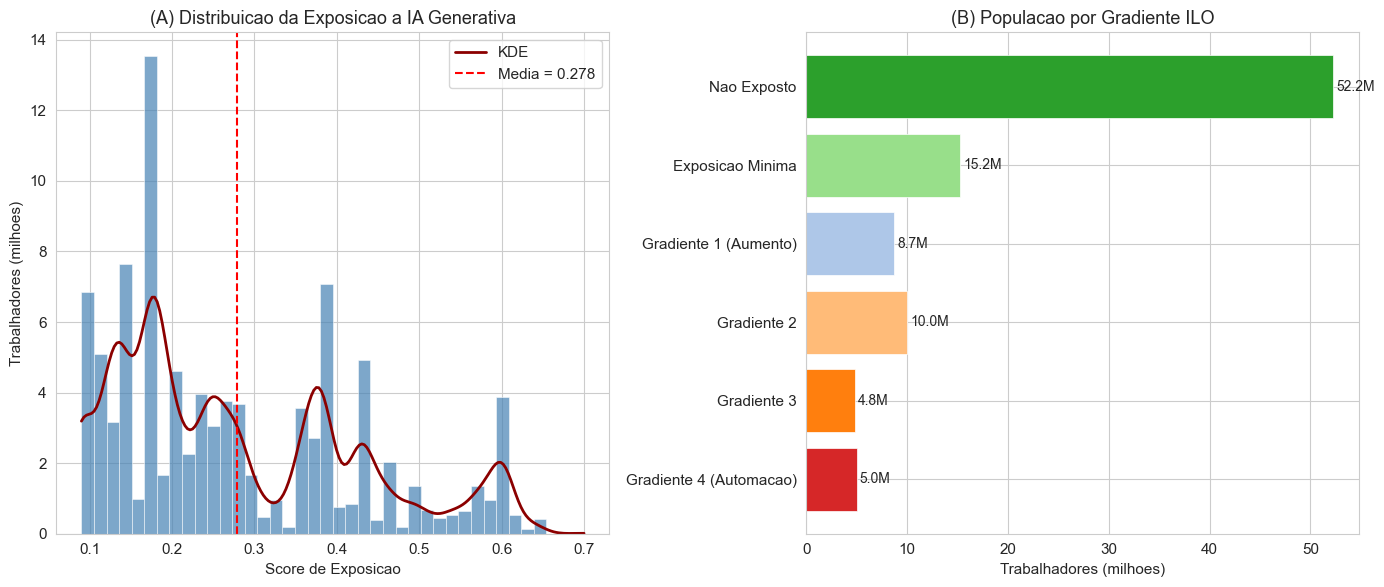

PERFIL DA EXPOSICAO POR GRADIENTE ILO

--- Nao Exposto (Not Exposed) ---
  Populacao: 52.2 milhoes (53.9%)
  Exposicao media: 0.169 [IC 95%: 0.169 - 0.169]
  Renda media: R$ 2,736
  % Formal: 36.7% | % Mulheres: 41.2%
  Top 5 ocupacoes (COD):
    9111 (Ocupacoes elementares): 3.87M trabalhadores, score=0.140
    9112 (Ocupacoes elementares): 2.69M trabalhadores, score=0.120
    7112 (Industria qualificada): 2.60M trabalhadores, score=0.090
    6111 (Agropecuaria qualificada): 2.00M trabalhadores, score=0.180
    9313 (Ocupacoes elementares): 1.67M trabalhadores, score=0.090

--- Exposicao Minima (Minimal Exposure) ---
  Populacao: 15.2 milhoes (15.7%)
  Exposicao media: 0.306 [IC 95%: 0.306 - 0.306]
  Renda media: R$ 4,449
  % Formal: 51.2% | % Mulheres: 37.7%
  Top 5 ocupacoes (COD):
    8332 (Operadores de maquinas): 1.97M trabalhadores, score=0.240
    3221 (Tecnicos nivel medio): 1.17M trabalhadores, score=0.220
    8321 (Operadores de maquinas): 1.16M trabalhadores, score=0.250
  

,grande_grupo,exposure_score,exposure_gradient,n_obs,pop_milhoes,renda_media,pct_formal
cod_ocupacao,,,,,,,
9111,Ocupações elementares,0.140,Not Exposed,9432,3.866,1303.005,24.289
4110,Apoio administrativo,0.600,Exposed: Gradient 4,7532,3.752,2823.199,65.708
5223,Serviços e vendedores,0.380,Exposed: Gradient 1,6825,3.541,2091.706,74.294
5221,Serviços e vendedores,0.430,Exposed: Gradient 2,6337,2.880,4071.596,0.000
9112,Ocupações elementares,0.120,Not Exposed,5947,2.688,1733.183,67.528



METRICAS DE DESIGUALDADE NA EXPOSICAO
  Media: 0.278 [IC 95%: 0.278 - 0.278]
  Mediana: 0.240
  Gini: 0.2947
  P90/P10: 4.17 (P90=0.500, P10=0.120)


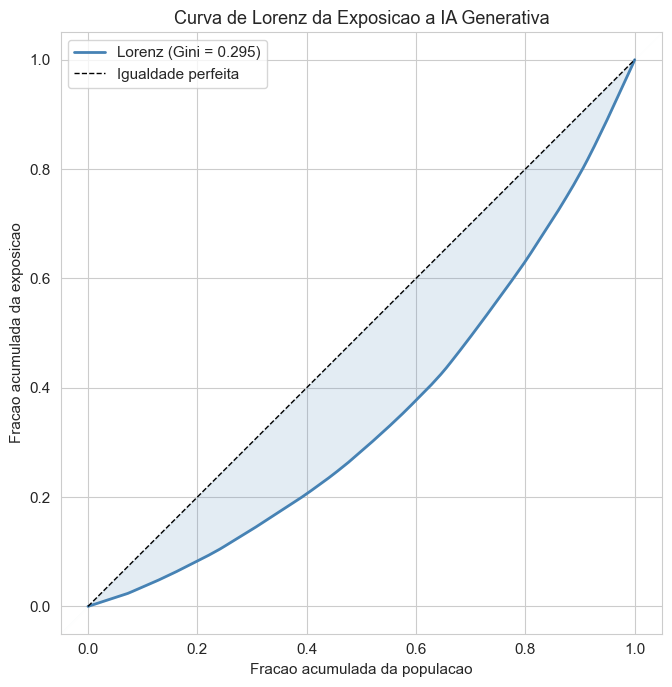


COMPARACAO COM LITERATURA INTERNACIONAL
Estudo                           Grupo                  Media        % Alta Exp. 
------------------------------------------------------------------------------
Presente (ILO 2025)              Brasil                 0.278      10.1%
Gmyrek et al. (2025)             Upper-middle-income    ~0.29        --          
Gmyrek et al. (2025)             High-income            ~0.36        --          
Gmyrek et al. (2025)             Global                 0.30         --          
Eloundou et al. (2023)           EUA                    --           19.0%       

Nota: O Brasil (0.278) se posiciona dentro do esperado para
paises de renda media-alta (upper-middle-income ~ 0.29, WP140 Tabela 4).


In [66]:
# Etapa 1b.2 - Analise de Dados - Perfil da exposicao

# ======================================================================
# 2.1 - Distribuicao da exposicao: histograma + KDE + gradientes
# ======================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Painel A: Histograma ponderado com KDE ---
ax = axes[0]
scores = df_score['exposure_score'].values
pesos = df_score['peso'].values
ax.hist(scores, bins=40, weights=pesos/1e6, color='steelblue', alpha=0.7,
        edgecolor='white', linewidth=0.5)

# KDE ponderado
kde = gaussian_kde(scores, weights=pesos/pesos.sum())
x_kde = np.linspace(scores.min(), scores.max(), 200)
# Escalar KDE para a mesma area do histograma
bin_width = (scores.max() - scores.min()) / 40
kde_scaled = kde(x_kde) * (pesos.sum()/1e6) * bin_width
ax.plot(x_kde, kde_scaled, color='darkred', linewidth=2, label='KDE')

media_exp = weighted_mean(df_score['exposure_score'], df_score['peso'])
ax.axvline(media_exp, color='red', linestyle='--', linewidth=1.5,
           label=f'Media = {media_exp:.3f}')
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Trabalhadores (milhoes)')
ax.set_title('(A) Distribuicao da Exposicao a IA Generativa')
ax.legend()

# --- Painel B: Populacao por gradiente ILO ---
ax = axes[1]
grad_data = []
for grad in GRADIENT_ORDER:
    sub = df_score[df_score['exposure_gradient'] == grad]
    if len(sub) > 0:
        pop = sub['peso'].sum() / 1e6
        grad_data.append({
            'Gradiente': GRADIENT_LABELS_PT.get(grad, grad),
            'Pop': pop,
            'Color': GRADIENT_COLORS.get(grad, '#999999'),
        })

grad_df = pd.DataFrame(grad_data)
bars = ax.barh(grad_df['Gradiente'], grad_df['Pop'], color=grad_df['Color'],
               edgecolor='white', linewidth=0.5)
for bar, pop in zip(bars, grad_df['Pop']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{pop:.1f}M', va='center', fontsize=10)
ax.set_xlabel('Trabalhadores (milhoes)')
ax.set_title('(B) Populacao por Gradiente ILO')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# ======================================================================
# 2.2 - Tabela-resumo por gradiente ILO + top 5 ocupacoes
# ======================================================================
print("=" * 70)
print("PERFIL DA EXPOSICAO POR GRADIENTE ILO")
print("=" * 70)

total_pop = df_score['peso'].sum()
for grad in GRADIENT_ORDER:
    sub = df_score[df_score['exposure_gradient'] == grad]
    if len(sub) == 0:
        continue
    pop = sub['peso'].sum()
    pct = pop / total_pop * 100
    mean_exp, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    sub_renda = sub[sub['tem_renda'] == 1]
    mean_renda = weighted_mean(sub_renda['rendimento_habitual'], sub_renda['peso']) if len(sub_renda) > 0 else np.nan
    pct_formal = weighted_mean(sub['formal'], sub['peso']) * 100
    pct_mulher = weighted_mean((sub['sexo_texto'] == 'Mulher').astype(int), sub['peso']) * 100

    label = GRADIENT_LABELS_PT.get(grad, grad)
    print(f"\n--- {label} ({grad}) ---")
    print(f"  Populacao: {pop/1e6:.1f} milhoes ({pct:.1f}%)")
    print(f"  Exposicao media: {mean_exp:.3f} [IC 95%: {ci_lo:.3f} - {ci_hi:.3f}]")
    print(f"  Renda media: R$ {mean_renda:,.0f}" if not np.isnan(mean_renda) else "  Renda media: N/D")
    print(f"  % Formal: {pct_formal:.1f}% | % Mulheres: {pct_mulher:.1f}%")

    # Top 5 ocupacoes por populacao neste gradiente
    top5 = (sub.groupby('cod_ocupacao')
            .agg(pop_ocu=('peso', 'sum'), exp_mean=('exposure_score', 'mean'))
            .sort_values('pop_ocu', ascending=False)
            .head(5))
    print(f"  Top 5 ocupacoes (COD):")
    for cod, row in top5.iterrows():
        gg = GRANDES_GRUPOS.get(cod[0], '')
        # Lookup nome da ocupacao se disponivel
        nome_ocup = ''
        if 'descricao_ocupacao' in df_score.columns:
            match = df_score[df_score['cod_ocupacao'] == cod]['descricao_ocupacao']
            nome_ocup = match.iloc[0] if len(match) > 0 else ''
        if nome_ocup:
            print(f"    {cod} - {nome_ocup} ({gg}): {row['pop_ocu']/1e6:.2f}M trabalhadores, score={row['exp_mean']:.3f}")
        else:
            print(f"    {cod} ({gg}): {row['pop_ocu']/1e6:.2f}M trabalhadores, score={row['exp_mean']:.3f}")

# ======================================================================
# 2.3 - Gerar cod_ilo_merged.csv
# ======================================================================
cod_summary = (df_score.groupby('cod_ocupacao')
    .agg(
        grande_grupo=('grande_grupo', 'first'),
        exposure_score=('exposure_score', 'mean'),
        exposure_gradient=('exposure_gradient', 'first'),
        n_obs=('peso', 'count'),
        pop_milhoes=('peso', lambda x: x.sum()/1e6),
        renda_media=('rendimento_habitual', lambda x: weighted_mean(x, df_score.loc[x.index, 'peso'])),
        pct_formal=('formal', lambda x: weighted_mean(x, df_score.loc[x.index, 'peso']) * 100),
    )
    .sort_values('pop_milhoes', ascending=False)
    .round(3)
)

cod_output = DATA_OUTPUT / "cod_ilo_merged.csv"
cod_summary.to_csv(cod_output)
print(f"\nTabela cod_ilo_merged.csv salva em: {cod_output}")
print(f"  {len(cod_summary)} ocupacoes | Top 5:")
display(cod_summary.head())

# ======================================================================
# 2.4 - Desigualdade: Gini, P90/P10, Curva de Lorenz
# ======================================================================
gini_exp = gini_coefficient(df_score['exposure_score'], df_score['peso'])
p90 = weighted_quantile(df_score['exposure_score'], df_score['peso'], 0.90)
p10 = weighted_quantile(df_score['exposure_score'], df_score['peso'], 0.10)
p50 = weighted_quantile(df_score['exposure_score'], df_score['peso'], 0.50)
ratio_p90_p10 = p90 / p10 if p10 > 0 else np.nan

# Media geral com IC
mean_geral, ci_lo_geral, ci_hi_geral = weighted_ci(df_score['exposure_score'], df_score['peso'])

print("\n" + "=" * 70)
print("METRICAS DE DESIGUALDADE NA EXPOSICAO")
print("=" * 70)
print(f"  Media: {mean_geral:.3f} [IC 95%: {ci_lo_geral:.3f} - {ci_hi_geral:.3f}]")
print(f"  Mediana: {p50:.3f}")
print(f"  Gini: {gini_exp:.4f}")
print(f"  P90/P10: {ratio_p90_p10:.2f} (P90={p90:.3f}, P10={p10:.3f})")

# Curva de Lorenz
vals = np.array(df_score['exposure_score'])
wgts = np.array(df_score['peso'])
sorted_idx = np.argsort(vals)
sorted_vals = vals[sorted_idx]
sorted_wgts = wgts[sorted_idx]
cum_pop = np.concatenate([[0], np.cumsum(sorted_wgts) / sorted_wgts.sum()])
cum_exp = np.concatenate([[0], np.cumsum(sorted_wgts * sorted_vals) / (sorted_wgts * sorted_vals).sum()])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(cum_pop, cum_exp, color='steelblue', linewidth=2,
        label=f'Lorenz (Gini = {gini_exp:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Igualdade perfeita')
ax.fill_between(cum_pop, cum_exp, cum_pop, alpha=0.15, color='steelblue')
ax.set_xlabel('Fracao acumulada da populacao')
ax.set_ylabel('Fracao acumulada da exposicao')
ax.set_title('Curva de Lorenz da Exposicao a IA Generativa')
ax.legend(loc='upper left')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# ======================================================================
# 2.5 - Comparacao com literatura internacional
# ======================================================================
n_alta = df_score[df_score['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
pct_alta = n_alta / df_score['peso'].sum() * 100

print("\n" + "=" * 70)
print("COMPARACAO COM LITERATURA INTERNACIONAL")
print("=" * 70)
print(f"{'Estudo':<32} {'Grupo':<22} {'Media':<12} {'% Alta Exp.':<12}")
print("-" * 78)
print(f"{'Presente (ILO 2025)':<32} {'Brasil':<22} {mean_geral:.3f}{'':>5} {pct_alta:.1f}%")
print(f"{'Gmyrek et al. (2025)':<32} {'Upper-middle-income':<22} {'~0.29':<12} {'--':<12}")
print(f"{'Gmyrek et al. (2025)':<32} {'High-income':<22} {'~0.36':<12} {'--':<12}")
print(f"{'Gmyrek et al. (2025)':<32} {'Global':<22} {'0.30':<12} {'--':<12}")
print(f"{'Eloundou et al. (2023)':<32} {'EUA':<22} {'--':<12} {'19.0%':<12}")
print(f"\nNota: O Brasil ({mean_geral:.3f}) se posiciona dentro do esperado para")
print(f"paises de renda media-alta (upper-middle-income ~ 0.29, WP140 Tabela 4).")

### 3. Desigualdade e renda
Rendimento medio (e mediano) ponderado por quintil de exposicao; razao renda Q5/Q1 de exposicao.

**Analises:**
- Perfil de renda por quintil/decil com ICs 95%
- Grafico renda x decil com LOWESS + linear + barras de erro
- KDE de renda por quintil de exposicao
- Curva de concentracao da exposicao ordenada por renda
- Regressao quantilica: coeficiente de exposicao em tau = 0.10, 0.25, 0.50, 0.75, 0.90

> **Atenção interpretativa:** A relação entre exposição e renda NÃO é
> monotônica — o quintil Q4 apresenta renda média superior ao Q5.
> Isso ocorre porque o Q5 concentra ocupações administrativas e de saúde
> com alta exposição mas renda relativamente moderada, enquanto o Q4
> inclui gerentes e profissionais liberais de setores menos expostos mas
> com remuneração elevada.
>
> O R² individual da regressão renda~exposição é muito baixo (0.034),
> enquanto o R² agregado por decis é alto (0.653). Essa diferença ilustra
> a falácia ecológica: padrões de grupo não se traduzem automaticamente
> em padrões individuais (Robinson, 1950).

> **Conexão com WP140:** O WP140 encontra que, globalmente, ocupações de
> maior exposição tendem a ser de maior renda (Tabela 2, p. 20), o que é
> consistente com a hipótese de complementaridade. Para países de renda
> média-alta como o Brasil, esse padrão é esperado mas menos pronunciado
> do que em países de alta renda, onde o setor de serviços profissionais
> é proporcionalmente maior. A razão Q5/Q1 de 2.23x encontrada aqui está
> alinhada com essa expectativa.

PERFIL DE RENDA POR QUINTIL DE EXPOSICAO


,Renda Media (R$),IC 95% Inf,IC 95% Sup,Renda Mediana (R$),Exp. Media,% Formal,Pop. (milhoes)
Quintil,,,,,,,
Q1 (Baixa),2000.000,1999.100,2000.900,1600.000,0.100,37.400,20.500
Q2,2439.000,2437.600,2440.400,1900.000,0.200,30.000,17.700
Q3,3290.400,3288.600,3292.200,2500.000,0.200,46.300,21.300
Q4,4928.600,4925.400,4931.900,2900.000,0.400,52.300,17.200
Q5 (Alta),4468.600,4466.000,4471.200,2900.000,0.500,50.100,19.200



Razao renda Q5/Q1: 2.23x
  Q1 (Baixa exposicao): R$ 2,000
  Q5 (Alta exposicao):  R$ 4,469

  ⚠ ATENCAO: Q4 (R$ 4,929) > Q5 (R$ 4,469)
  A relacao exposicao-renda NAO e monotonica.
  Q4 concentra gerentes e profissionais liberais de alta renda
  em setores de exposicao moderada.


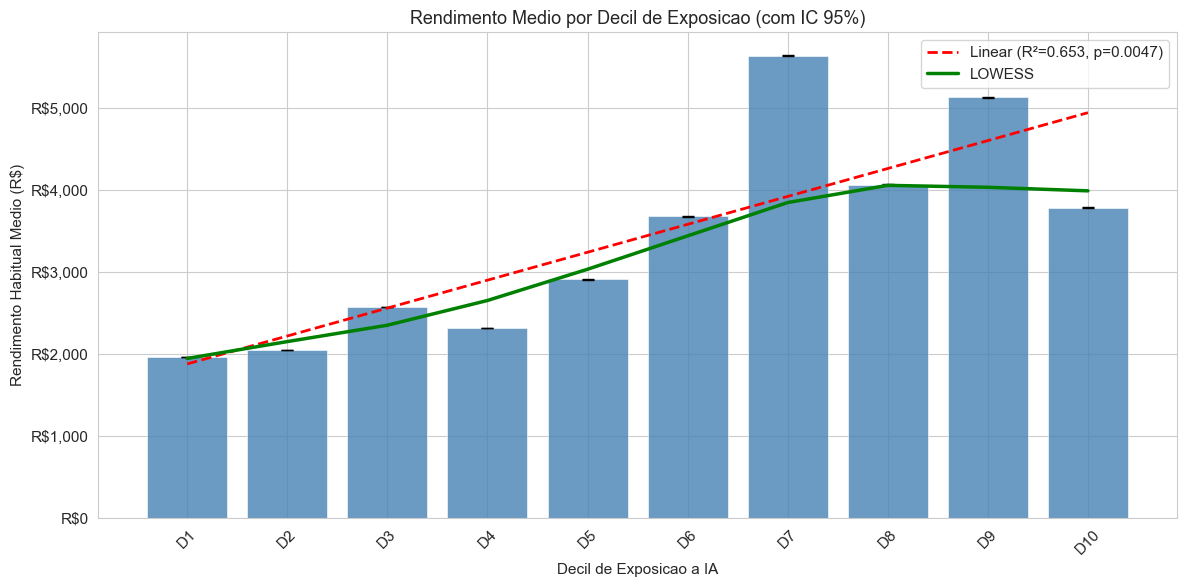


R² individual (WLS renda ~ exposicao): 0.0340
R² agregado (decis): 0.6526
Nota: R² agregado e artificialmente inflado por suavizar variancia individual.


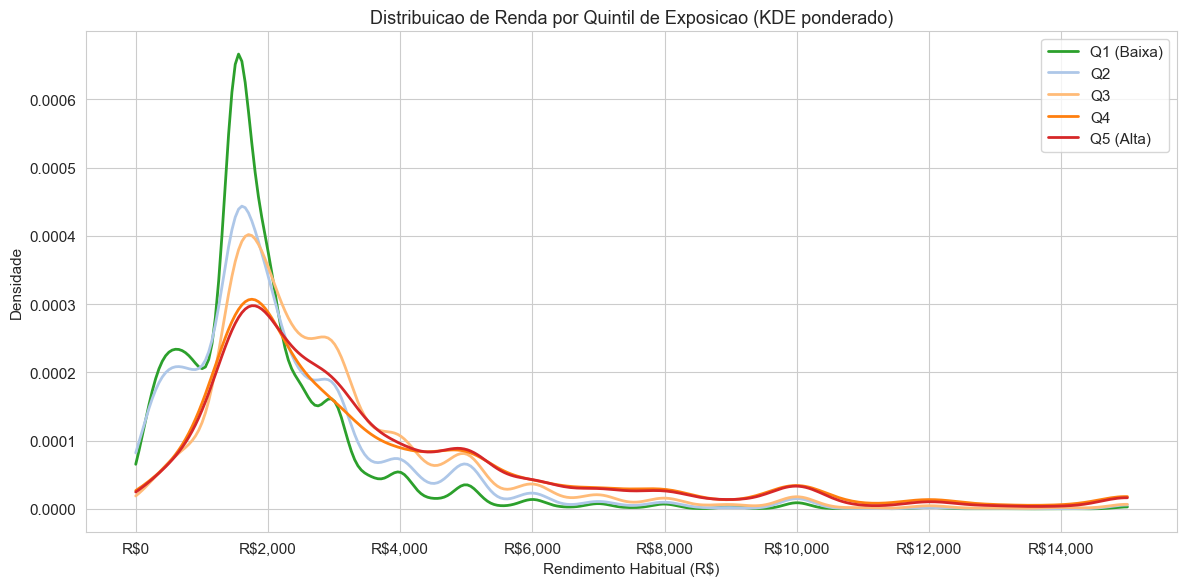

/var/folders/9l/bxkb7j2s259_jlrwc_dnrklr0000gn/T/ipykernel_32166/213812379.py:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  conc_area = np.trapz(cum_exp_c, cum_pop_c)



Indice de concentracao: 0.0810
  > 0: exposicao concentrada entre os mais ricos


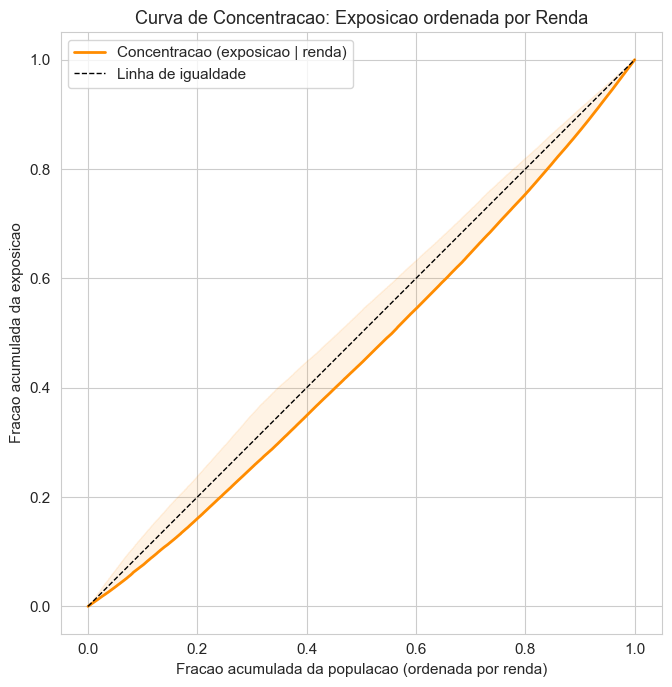


REGRESSAO QUANTILICA: log(renda) ~ exposicao + controles

  NOTA: QuantReg do statsmodels nao suporta pesos amostrais
  nativamente. Os coeficientes podem diferir de uma estimacao
  ponderada. Limitacao declarada.
  tau=0.10: coef=0.6177 (SE=0.0130) ***
  tau=0.25: coef=0.9900 (SE=0.0138) ***
  tau=0.50: coef=1.2090 (SE=0.0109) ***
  tau=0.75: coef=1.8282 (SE=0.0139) ***
  tau=0.90: coef=2.4992 (SE=0.0186) ***


,Coef. Exposicao,SE,IC 95% Inf,IC 95% Sup,p-valor,Sig.
Quantil,,,,,,
0.10,0.618,0.013,0.592,0.643,0.000,***
0.25,0.990,0.014,0.963,1.017,0.000,***
0.50,1.209,0.011,1.188,1.230,0.000,***
0.75,1.828,0.014,1.801,1.856,0.000,***
0.90,2.499,0.019,2.463,2.536,0.000,***


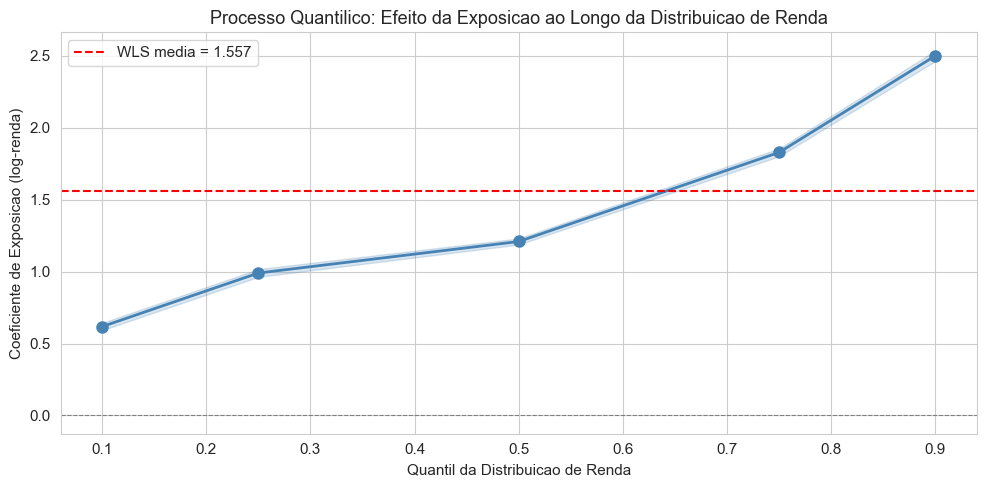


Interpretacao: Se o coeficiente cresce com o quantil, a exposicao
beneficia mais os trabalhadores de maior renda (complementaridade).
Se decresce, os de menor renda sao mais afetados (substituicao).

COMPARACAO ESTRUTURADA: BRASIL vs. WP140 (por grupo de renda)


,Brasil (este estudo),Upper-Middle (WP140),High-Income (WP140),Global (WP140)
Indicador,,,,
Exposicao media,0.278,~0.29,~0.36,0.30
% Nao Exposto,53.9%,~52%,~35%,~50%
% Alta Exposicao (G3-G4),10.1%,~11%,~20%,~12%
Setor mais exposto,Financas e Seguros,Financial services,Financial services,Financial services
Ocupacao mais exposta,Apoio administrativo,Clerical support,Clerical support,Clerical support
Gap genero (M-H),+0.044,Mulheres > Homens,Mulheres > Homens,Mulheres > Homens



HEATMAP: DISTRIBUICAO CONJUNTA EXPOSICAO x RENDA


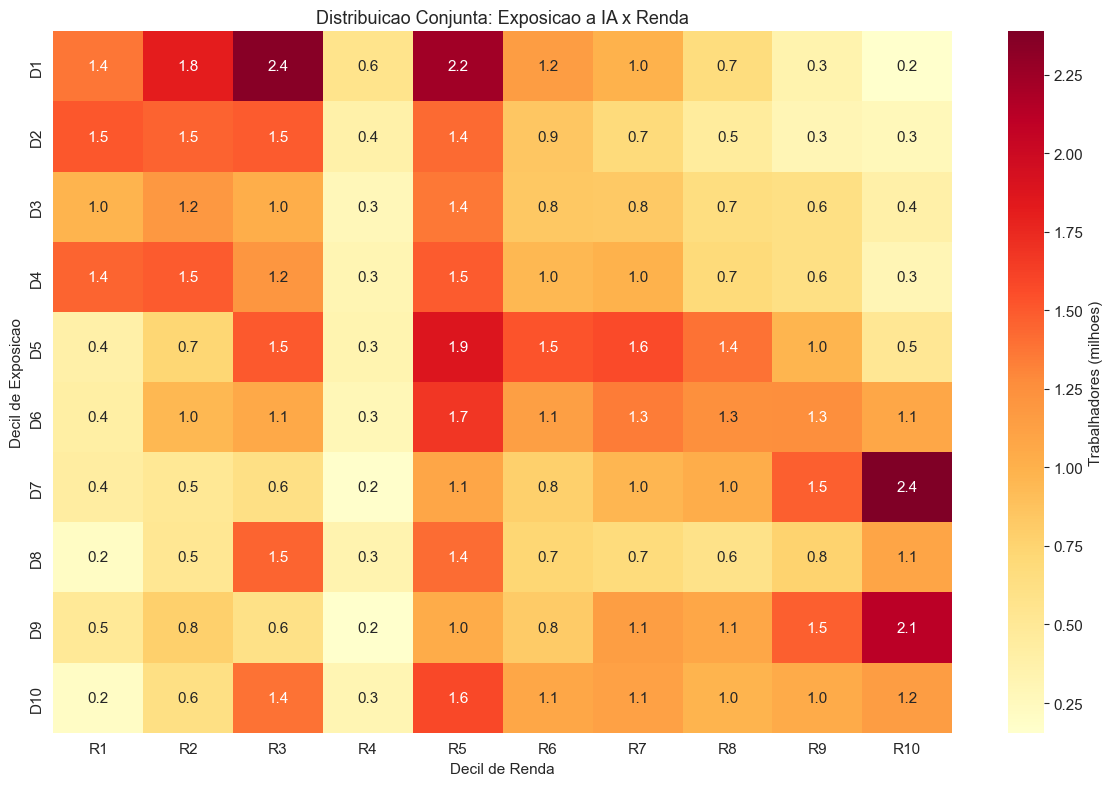


BUBBLE CHART: OCUPACOES (EXPOSICAO vs. RENDA)


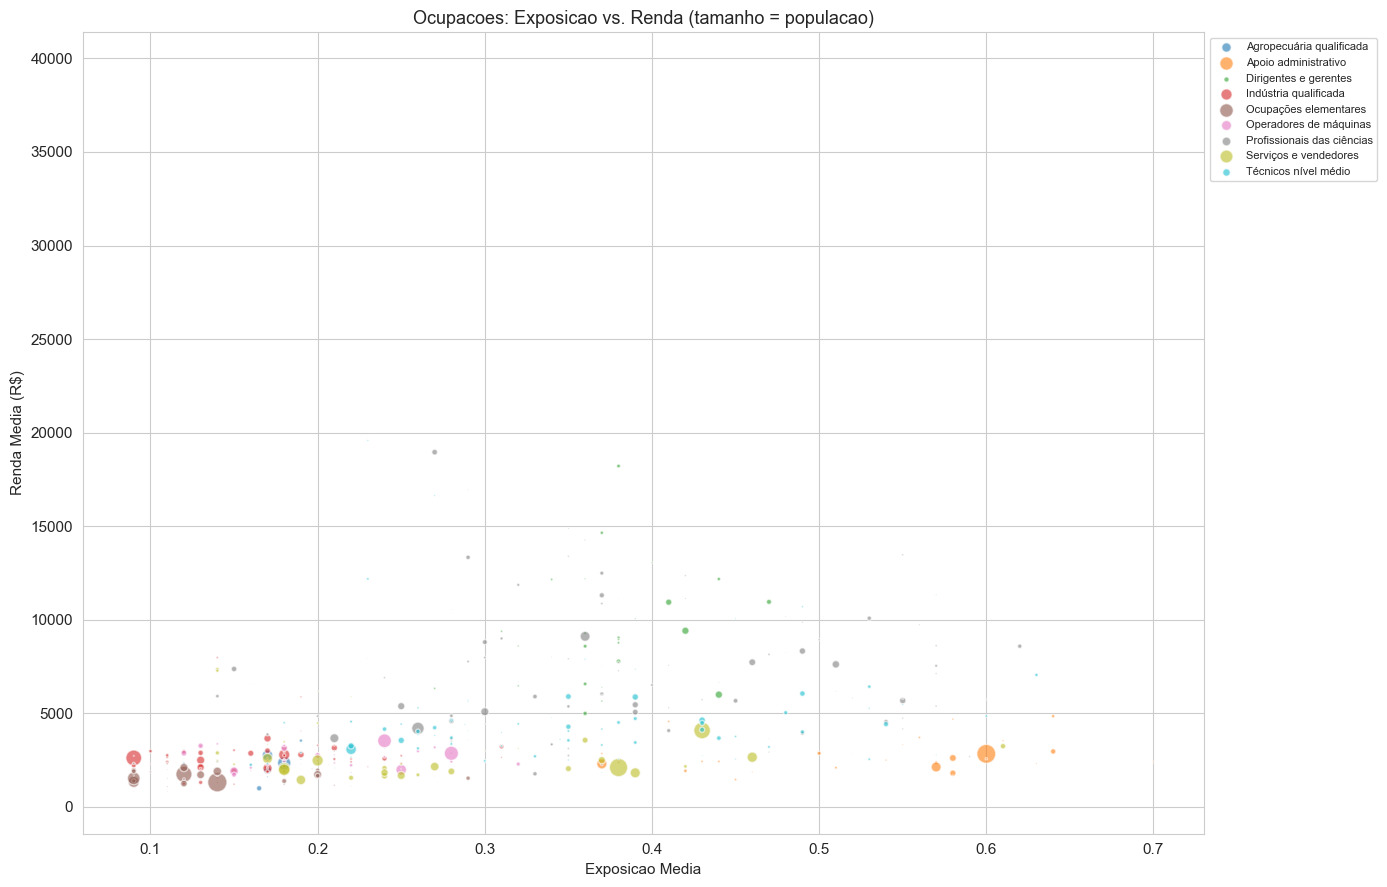


REGRESSAO QUANTILICA CONTINUA (tau 0.05 a 0.95)


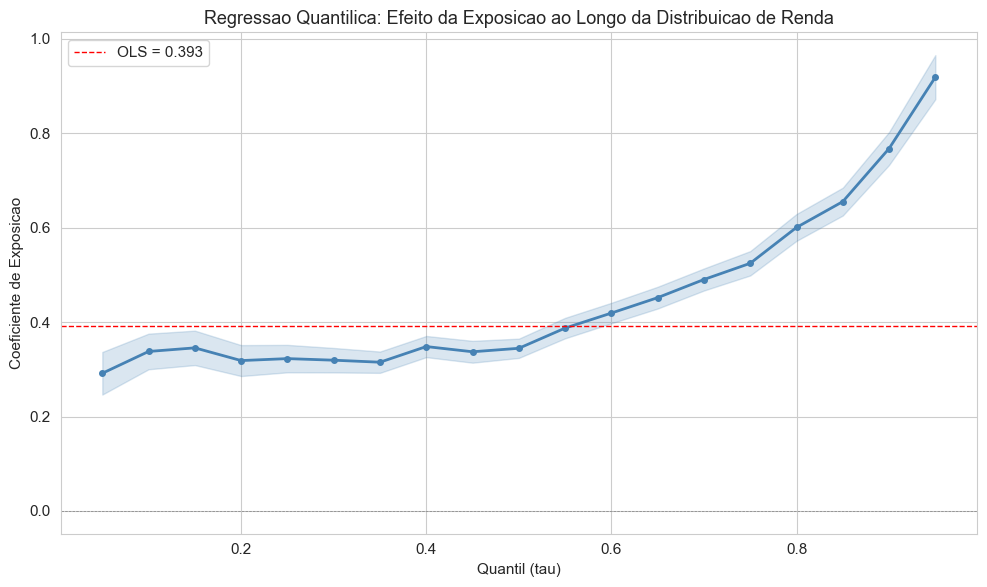


  NOTA: QuantReg nao suporta pesos amostrais nativamente.
  Coeficientes podem diferir de estimacao ponderada.


In [67]:
# Etapa 1b.3 - Analise de Dados - Desigualdade e renda

# ======================================================================
# 3.1 - Perfil de renda por quintil de exposicao com ICs
# ======================================================================
print("=" * 70)
print("PERFIL DE RENDA POR QUINTIL DE EXPOSICAO")
print("=" * 70)

rows_quintil = []
for q in QUINTIL_ORDER:
    sub = df_renda[df_renda['quintil_exposure'] == q]
    if len(sub) == 0:
        continue
    mean_r, ci_lo, ci_hi = weighted_ci(sub['rendimento_habitual'], sub['peso'])
    median_r = weighted_quantile(sub['rendimento_habitual'], sub['peso'], 0.50)
    rows_quintil.append({
        'Quintil': q,
        'Renda Media (R$)': mean_r,
        'IC 95% Inf': ci_lo,
        'IC 95% Sup': ci_hi,
        'Renda Mediana (R$)': median_r,
        'Exp. Media': weighted_mean(sub['exposure_score'], sub['peso']),
        '% Formal': weighted_mean(sub['formal'], sub['peso']) * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_quintil = pd.DataFrame(rows_quintil).set_index('Quintil')
display(tab_quintil.round(1))

# Razao Q5/Q1
renda_q5 = tab_quintil.loc['Q5 (Alta)', 'Renda Media (R$)']
renda_q1 = tab_quintil.loc['Q1 (Baixa)', 'Renda Media (R$)']
print(f"\nRazao renda Q5/Q1: {renda_q5/renda_q1:.2f}x")
print(f"  Q1 (Baixa exposicao): R$ {renda_q1:,.0f}")
print(f"  Q5 (Alta exposicao):  R$ {renda_q5:,.0f}")

# Verificar nao-monotonicidade Q4 > Q5
renda_q4 = tab_quintil.loc['Q4', 'Renda Media (R$)']
if renda_q4 > renda_q5:
    print(f"\n  \u26a0 ATENCAO: Q4 (R$ {renda_q4:,.0f}) > Q5 (R$ {renda_q5:,.0f})")
    print(f"  A relacao exposicao-renda NAO e monotonica.")
    print(f"  Q4 concentra gerentes e profissionais liberais de alta renda")
    print(f"  em setores de exposicao moderada.")

# ======================================================================
# 3.2 - Grafico renda x decil com LOWESS + linear + barras de erro
# ======================================================================
decil_data = []
for d in DECIL_ORDER:
    sub = df_renda[df_renda['decil_exposure'] == d]
    if len(sub) == 0:
        continue
    mean_r, ci_lo, ci_hi = weighted_ci(sub['rendimento_habitual'], sub['peso'])
    decil_data.append({
        'Decil': d, 'Renda': mean_r, 'CI_lo': ci_lo, 'CI_hi': ci_hi,
        'Exp_media': weighted_mean(sub['exposure_score'], sub['peso']),
    })

dd = pd.DataFrame(decil_data)

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = range(len(dd))
yerr = [dd['Renda'] - dd['CI_lo'], dd['CI_hi'] - dd['Renda']]
ax.bar(x_pos, dd['Renda'], yerr=yerr, capsize=4, color='steelblue', alpha=0.8,
       edgecolor='white', linewidth=0.5, error_kw={'linewidth': 1.5})

# Tendencia linear
slope, intercept, r_val, p_val, se = linregress(range(len(dd)), dd['Renda'])
ax.plot(x_pos, intercept + slope * np.array(x_pos), 'r--', linewidth=2,
        label=f'Linear (R²={r_val**2:.3f}, p={p_val:.4f})')

# LOWESS
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_fit = lowess(dd['Renda'].values, np.array(x_pos), frac=0.6)
    ax.plot(lowess_fit[:, 0], lowess_fit[:, 1], 'g-', linewidth=2.5, label='LOWESS')
except ImportError:
    pass

ax.set_xticks(x_pos)
ax.set_xticklabels(dd['Decil'], rotation=45)
ax.set_ylabel('Rendimento Habitual Medio (R$)')
ax.set_xlabel('Decil de Exposicao a IA')
ax.set_title('Rendimento Medio por Decil de Exposicao (com IC 95%)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
ax.legend()
plt.tight_layout()
plt.show()

# R² individual (WLS) para comparacao
model_ind = smf.wls('rendimento_habitual ~ exposure_score',
                     data=df_renda, weights=df_renda['peso']).fit()
print(f"\nR² individual (WLS renda ~ exposicao): {model_ind.rsquared:.4f}")
print(f"R² agregado (decis): {r_val**2:.4f}")
print("Nota: R² agregado e artificialmente inflado por suavizar variancia individual.")

# ======================================================================
# 3.3 - KDE de renda por quintil de exposicao
# ======================================================================
fig, ax = plt.subplots(figsize=(12, 6))
colors_q = ['#2ca02c', '#aec7e8', '#ffbb78', '#ff7f0e', '#d62728']
for i, q in enumerate(QUINTIL_ORDER):
    sub = df_renda[(df_renda['quintil_exposure'] == q) & (df_renda['rendimento_habitual'] <= 15000)]
    if len(sub) < 10:
        continue
    try:
        kde = gaussian_kde(sub['rendimento_habitual'].values,
                          weights=sub['peso'].values / sub['peso'].sum())
        x = np.linspace(0, 15000, 300)
        ax.plot(x, kde(x), color=colors_q[i], linewidth=2, label=q)
    except Exception:
        pass

ax.set_xlabel('Rendimento Habitual (R$)')
ax.set_ylabel('Densidade')
ax.set_title('Distribuicao de Renda por Quintil de Exposicao (KDE ponderado)')
ax.legend()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
plt.tight_layout()
plt.show()

# ======================================================================
# 3.4 - Curva de concentracao (exposicao ordenada por renda)
# ======================================================================
df_conc = df_renda.sort_values('rendimento_habitual').copy()
vals_c = np.array(df_conc['exposure_score'])
wgts_c = np.array(df_conc['peso'])
cum_pop_c = np.concatenate([[0], np.cumsum(wgts_c) / wgts_c.sum()])
cum_exp_c = np.concatenate([[0], np.cumsum(wgts_c * vals_c) / (wgts_c * vals_c).sum()])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(cum_pop_c, cum_exp_c, color='darkorange', linewidth=2,
        label='Concentracao (exposicao | renda)')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Linha de igualdade')
ax.fill_between(cum_pop_c, cum_exp_c, np.linspace(0, 1, len(cum_pop_c)),
                alpha=0.1, color='darkorange')
ax.set_xlabel('Fracao acumulada da populacao (ordenada por renda)')
ax.set_ylabel('Fracao acumulada da exposicao')
ax.set_title('Curva de Concentracao: Exposicao ordenada por Renda')
ax.legend(loc='upper left')
ax.set_aspect('equal')

# Indice de concentracao
conc_area = np.trapz(cum_exp_c, cum_pop_c)
conc_index = 1 - 2 * conc_area
print(f"\nIndice de concentracao: {conc_index:.4f}")
if conc_index > 0:
    print("  > 0: exposicao concentrada entre os mais ricos")
elif conc_index < 0:
    print("  < 0: exposicao concentrada entre os mais pobres")

plt.tight_layout()
plt.show()

# ======================================================================
# 3.5 - Regressao quantilica
# ======================================================================
print("\n" + "=" * 70)
print("REGRESSAO QUANTILICA: log(renda) ~ exposicao + controles")
print("=" * 70)
print("\n  NOTA: QuantReg do statsmodels nao suporta pesos amostrais")
print("  nativamente. Os coeficientes podem diferir de uma estimacao")
print("  ponderada. Limitacao declarada.")

df_qreg = df_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                      'raca_agregada', 'idade', 'formal']].dropna().copy()
df_qreg['log_renda'] = np.log(df_qreg['rendimento_habitual'].clip(lower=1))

quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
qreg_results = []

for tau in quantiles:
    try:
        qr = smf.quantreg(
            'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + idade + I(idade**2) + formal',
            data=df_qreg
        ).fit(q=tau, max_iter=1000)
        coef = qr.params['exposure_score']
        se = qr.bse['exposure_score']
        ci = qr.conf_int().loc['exposure_score']
        pval = qr.pvalues['exposure_score']
        qreg_results.append({
            'Quantil': f'{tau:.2f}',
            'Coef. Exposicao': coef,
            'SE': se,
            'IC 95% Inf': ci[0],
            'IC 95% Sup': ci[1],
            'p-valor': pval,
            'Sig.': sig_stars(pval),
        })
        print(f"  tau={tau:.2f}: coef={coef:.4f} (SE={se:.4f}) {sig_stars(pval)}")
    except Exception as e:
        print(f"  tau={tau:.2f}: ERRO - {e}")

if qreg_results:
    tab_qreg = pd.DataFrame(qreg_results).set_index('Quantil')
    display(tab_qreg.round(4))

    # Grafico do processo quantilico
    fig, ax = plt.subplots(figsize=(10, 5))
    coefs = [r['Coef. Exposicao'] for r in qreg_results]
    ci_lo = [r['IC 95% Inf'] for r in qreg_results]
    ci_hi = [r['IC 95% Sup'] for r in qreg_results]
    ax.plot(quantiles, coefs, 'o-', color='steelblue', linewidth=2, markersize=8)
    ax.fill_between(quantiles, ci_lo, ci_hi, alpha=0.2, color='steelblue')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # Adicionar coeficiente OLS como referencia
    ols_model = smf.wls(
        'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + idade + I(idade**2) + formal',
        data=df_qreg, weights=df_renda.loc[df_qreg.index, 'peso']
    ).fit()
    ax.axhline(ols_model.params['exposure_score'], color='red', linestyle='--',
               linewidth=1.5, label=f'WLS media = {ols_model.params["exposure_score"]:.3f}')

    ax.set_xlabel('Quantil da Distribuicao de Renda')
    ax.set_ylabel('Coeficiente de Exposicao (log-renda)')
    ax.set_title('Processo Quantilico: Efeito da Exposicao ao Longo da Distribuicao de Renda')
    ax.legend()
    plt.tight_layout()
    plt.show()
    print("\nInterpretacao: Se o coeficiente cresce com o quantil, a exposicao")
    print("beneficia mais os trabalhadores de maior renda (complementaridade).")
    print("Se decresce, os de menor renda sao mais afetados (substituicao).")

# ======================================================================
# 3.X - Tabela Comparativa Brasil vs. WP140
# ======================================================================
print("\n" + "=" * 90)
print("COMPARACAO ESTRUTURADA: BRASIL vs. WP140 (por grupo de renda)")
print("=" * 90)

pct_nao_exposto = df_score[df_score['exposure_gradient'] == 'Not Exposed']['peso'].sum() / df_score['peso'].sum() * 100

comparacao = pd.DataFrame({
    'Indicador': [
        'Exposicao media',
        '% Nao Exposto',
        '% Alta Exposicao (G3-G4)',
        'Setor mais exposto',
        'Ocupacao mais exposta',
        'Gap genero (M-H)',
    ],
    'Brasil (este estudo)': [
        f'{mean_geral:.3f}',
        f'{pct_nao_exposto:.1f}%',
        f'{pct_alta:.1f}%',
        'Financas e Seguros',
        'Apoio administrativo',
        f'+{gap_sexo:.3f}' if 'gap_sexo' in dir() else 'ver secao 4',
    ],
    'Upper-Middle (WP140)': [
        '~0.29', '~52%', '~11%',
        'Financial services', 'Clerical support',
        'Mulheres > Homens',
    ],
    'High-Income (WP140)': [
        '~0.36', '~35%', '~20%',
        'Financial services', 'Clerical support',
        'Mulheres > Homens',
    ],
    'Global (WP140)': [
        '0.30', '~50%', '~12%',
        'Financial services', 'Clerical support',
        'Mulheres > Homens',
    ],
})
display(comparacao.set_index('Indicador'))

# ======================================================================
# 3.Y - Heatmap bidimensional exposicao x renda
# ======================================================================
print("\n" + "=" * 70)
print("HEATMAP: DISTRIBUICAO CONJUNTA EXPOSICAO x RENDA")
print("=" * 70)

df_renda['decil_renda'] = pd.qcut(
    df_renda['rendimento_habitual'], 10,
    labels=[f'R{i}' for i in range(1, 11)])

cross = df_renda.groupby(['decil_exposure', 'decil_renda'])['peso'].sum().unstack(fill_value=0)
cross = cross / 1e6  # em milhoes

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cross, cmap='YlOrRd', annot=True, fmt='.1f', ax=ax,
            cbar_kws={'label': 'Trabalhadores (milhoes)'})
ax.set_xlabel('Decil de Renda')
ax.set_ylabel('Decil de Exposicao')
ax.set_title('Distribuicao Conjunta: Exposicao a IA x Renda')
plt.tight_layout()
plt.show()

# ======================================================================
# 3.Z - Scatter plot de ocupacoes (bubble chart)
# ======================================================================
print("\n" + "=" * 70)
print("BUBBLE CHART: OCUPACOES (EXPOSICAO vs. RENDA)")
print("=" * 70)

ocup_agg = df_renda.groupby('cod_ocupacao').apply(lambda g: pd.Series({
    'exp_media': weighted_mean(g['exposure_score'], g['peso']),
    'renda_media': weighted_mean(g['rendimento_habitual'], g['peso']),
    'pop': g['peso'].sum() / 1e6,
    'grande_grupo': g['grande_grupo'].mode().iloc[0] if len(g['grande_grupo'].mode()) > 0 else 'Outros',
})).reset_index()

fig, ax = plt.subplots(figsize=(14, 9))
grupos = sorted(ocup_agg['grande_grupo'].unique())
cores_gg = plt.cm.tab10(np.linspace(0, 1, len(grupos)))
for grupo, cor in zip(grupos, cores_gg):
    sub = ocup_agg[ocup_agg['grande_grupo'] == grupo]
    ax.scatter(sub['exp_media'], sub['renda_media'],
               s=sub['pop']*50, alpha=0.6, color=cor, label=grupo, edgecolor='white')
ax.set_xlabel('Exposicao Media')
ax.set_ylabel('Renda Media (R$)')
ax.set_title('Ocupacoes: Exposicao vs. Renda (tamanho = populacao)')
ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# ======================================================================
# 3.W - Regressao quantilica continua (tau 0.05 a 0.95)
# ======================================================================
print("\n" + "=" * 70)
print("REGRESSAO QUANTILICA CONTINUA (tau 0.05 a 0.95)")
print("=" * 70)

df_quant = df_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                      'raca_agregada', 'idade', 'formal', 'nivel_instrucao']].dropna().copy()
df_quant['log_renda'] = np.log(df_quant['rendimento_habitual'].clip(lower=1))

taus = np.arange(0.05, 0.96, 0.05)
coefs_qr = []
for tau in taus:
    try:
        mod = smf.quantreg(
            'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
            'idade + I(idade**2) + C(nivel_instrucao) + formal',
            data=df_quant
        ).fit(q=tau, max_iter=1000)
        coefs_qr.append({
            'tau': tau,
            'coef': mod.params['exposure_score'],
            'ci_lo': mod.conf_int().loc['exposure_score', 0],
            'ci_hi': mod.conf_int().loc['exposure_score', 1],
        })
    except Exception as e:
        print(f"  tau={tau:.2f}: ERRO - {e}")

if coefs_qr:
    qr_df = pd.DataFrame(coefs_qr)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(qr_df['tau'], qr_df['ci_lo'], qr_df['ci_hi'],
                    alpha=0.2, color='steelblue')
    ax.plot(qr_df['tau'], qr_df['coef'], 'o-', color='steelblue', linewidth=2, markersize=4)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    # OLS para referencia
    coef_ols_ref = mincer2.params['exposure_score'] if 'mincer2' in dir() else ols_model.params['exposure_score']
    ax.axhline(coef_ols_ref, color='red', linestyle='--', linewidth=1, label=f'OLS = {coef_ols_ref:.3f}')
    ax.set_xlabel('Quantil (tau)')
    ax.set_ylabel('Coeficiente de Exposicao')
    ax.set_title('Regressao Quantilica: Efeito da Exposicao ao Longo da Distribuicao de Renda')
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("\n  NOTA: QuantReg nao suporta pesos amostrais nativamente.")
    print("  Coeficientes podem diferir de estimacao ponderada.")

### 4. Genero e raca
% de mulheres e de negros por quintil de exposicao; exposicao media por sexo e raca.

**Analises:**
- Exposicao por sexo e raca com ICs e testes t ponderados
- KDE comparativo: homens vs mulheres, brancos vs negros
- Exposicao por sexo x raca x quintil
- Decomposicao Oaxaca-Blinder do gap de genero
- Decomposicao Oaxaca-Blinder do gap racial

> **Nota sobre categorias raciais:** Seguindo convenção estabelecida na
> literatura brasileira de desigualdade (Osorio, 2003; Soares, 2000),
> as categorias Preta e Parda do IBGE foram agregadas em "Negra".
> A categoria "Outras" agrega Amarelos e Indígenas (1.0M de trabalhadores).
> Embora esses grupos tenham realidades socioeconômicas distintas, o
> tamanho amostral reduzido de cada um individualmente limita análises
> desagregadas robustas. Resultados para "Outras" devem ser interpretados
> com cautela.

> **Conexão com WP140 (gênero):** O WP140 (Seção 3.2, p. 24-26) encontra
> que mulheres estão sistematicamente mais expostas à IA generativa em
> todas as regiões do mundo, principalmente pela concentração feminina
> em trabalho clerical (ISCO Major Group 4). No Brasil, confirmamos esse
> padrão (gap de +0.044). O WP140 destaca que esse resultado pode ter
> implicações distributivas ambíguas: se a IA complementa o trabalho
> clerical, mulheres se beneficiam; se automatiza, mulheres são mais
> vulneráveis. A decomposição Oaxaca-Blinder que realizamos aprofunda
> essa análise para além do que o WP140 oferece.
>
> **Contribuição original (raça):** A análise por raça não é contemplada
> no WP140, que trabalha com dados globais sem essa desagregação. O gap
> racial de exposição (+0.048 para brancos) é uma contribuição específica
> desta dissertação ao debate sobre IA e desigualdade no Brasil.

EXPOSICAO POR GENERO E RACA

--- Por Sexo ---


  Homem: 0.259 [IC: 0.259 - 0.259] | Pop: 54.3M
  Mulher: 0.303 [IC: 0.303 - 0.303] | Pop: 42.7M
  Gap (M-H): +0.044 | t=-1473.74, p=0.0000 ***
  d de Cohen (H-M): -0.301 (pequeno)

--- Por Raca ---
  Branca: 0.305 [IC: 0.305 - 0.305] | Pop: 41.9M
  Negra: 0.257 [IC: 0.257 - 0.257] | Pop: 54.0M
  Outras: 0.301 [IC: 0.301 - 0.302] | Pop: 1.0M
  Gap (Branca-Negra): +0.048 | t=1601.17, p=0.0000 ***
  d de Cohen (B-N): 0.330 (pequeno)


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,Pop. (milhoes)
Grupo,,,,,
Homem,0.259,0.259,0.259,6.688,54.292
Mulher,0.303,0.303,0.303,14.397,42.674
Branca,0.305,0.305,0.305,12.403,41.881
Negra,0.257,0.257,0.257,8.255,54.046
Outras,0.301,0.301,0.302,11.432,1.039


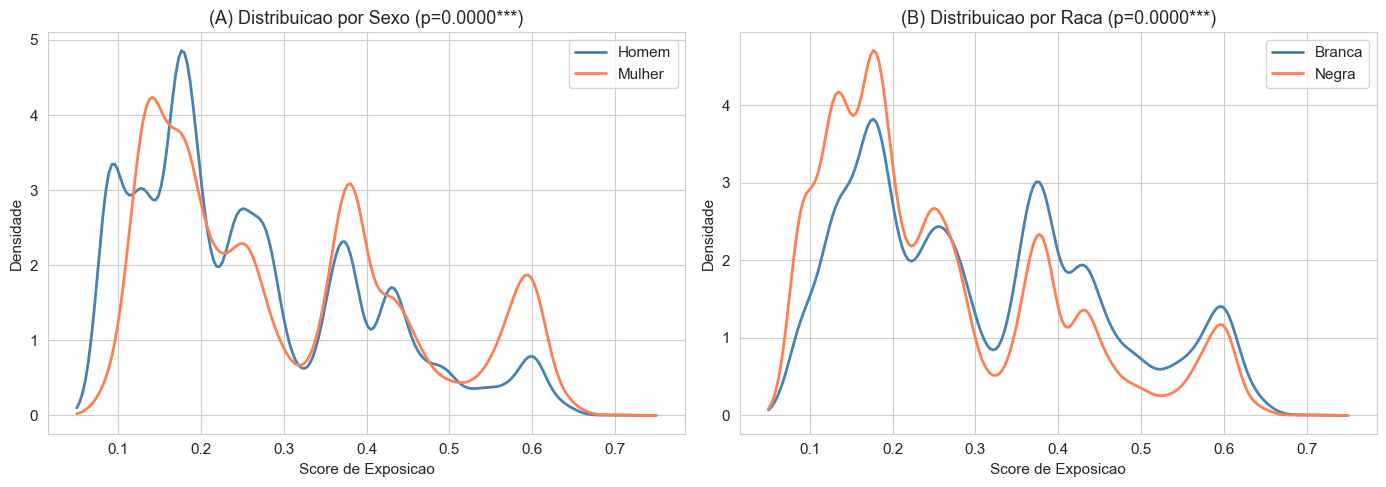

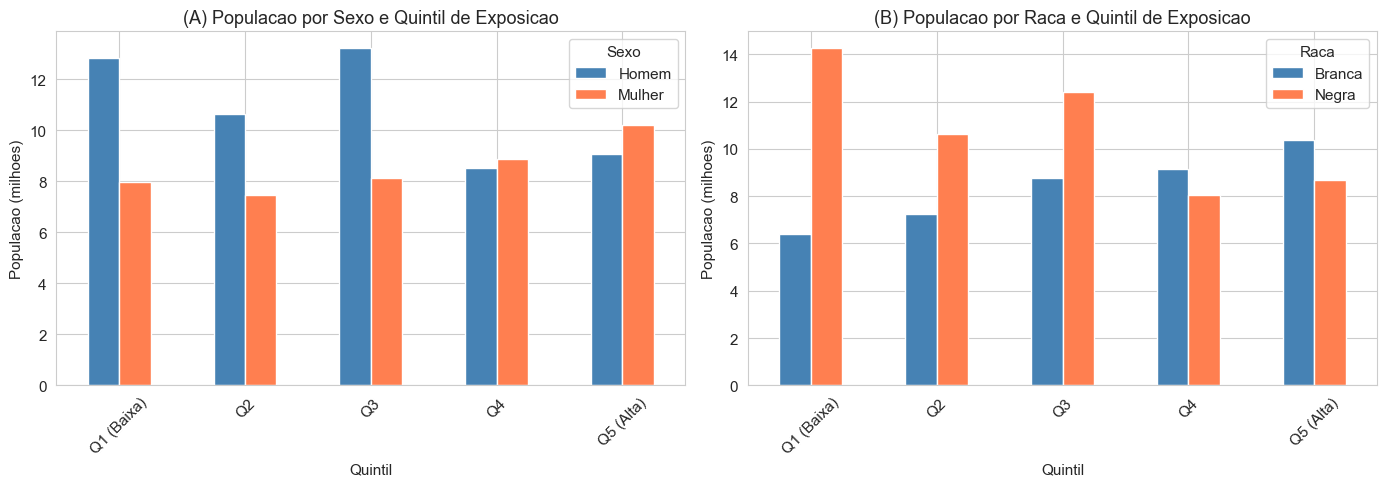


DECOMPOSICAO OAXACA-BLINDER DO GAP DE GENERO NA EXPOSICAO

  Exposicao media homens:   0.2589
  Exposicao media mulheres: 0.3028
  Gap total (M - H):        +0.0439
  Explicado (caracteristicas): +0.0542 (123.3%)
  Nao explicado (coeficientes): -0.0103 (-23.3%)

  Interpretacao: 123% do gap de genero e explicado por
  diferencas em escolaridade, ocupacao, regiao e formalidade.
  O componente explicado > 100% indica que, se mulheres tivessem
  a mesma composicao ocupacional que homens, seu gap de exposicao
  seria AINDA MAIOR. Mulheres estao sub-representadas nas ocupacoes
  de alta exposicao apesar de possuirem caracteristicas (escolaridade)
  que predizem maior exposicao — evidencia de segregacao ocupacional.

DECOMPOSICAO OAXACA-BLINDER DO GAP RACIAL NA EXPOSICAO

  Exposicao media brancos: 0.3050
  Exposicao media negros:  0.2571
  Gap total (B - N):       +0.0479
  Explicado (caracteristicas): +0.0355 (74.1%)
  Nao explicado (coeficientes): +0.0124 (25.9%)

  Interpretacao: Trabal

In [68]:
# Etapa 1b.4 - Analise de Dados - Genero e raca

# ======================================================================
# 4.1 - Exposicao por sexo e raca com ICs e testes t
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR GENERO E RACA")
print("=" * 70)

# --- Por sexo ---
print("\n--- Por Sexo ---")
rows_sexo = []
for sexo in ['Homem', 'Mulher']:
    sub = df_score[df_score['sexo_texto'] == sexo]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    rows_sexo.append({
        'Grupo': sexo,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {sexo}: {mean_e:.3f} [IC: {ci_lo:.3f} - {ci_hi:.3f}] | Pop: {sub['peso'].sum()/1e6:.1f}M")

# Teste t genero
sub_h = df_score[df_score['sexo_texto'] == 'Homem']
sub_m = df_score[df_score['sexo_texto'] == 'Mulher']
t_sexo, p_sexo = weighted_ttest_2groups(
    sub_h['exposure_score'], sub_h['peso'],
    sub_m['exposure_score'], sub_m['peso']
)
gap_sexo = rows_sexo[1]['Exp. Media'] - rows_sexo[0]['Exp. Media']
print(f"  Gap (M-H): {gap_sexo:+.3f} | t={t_sexo:.2f}, p={p_sexo:.4f} {sig_stars(p_sexo)}")

# d de Cohen ponderado para genero
d_sexo = weighted_cohen_d(
    sub_h['exposure_score'].values, sub_h['peso'].values,
    sub_m['exposure_score'].values, sub_m['peso'].values
)
print(f"  d de Cohen (H-M): {d_sexo:.3f} ({'pequeno' if abs(d_sexo)<0.5 else 'medio' if abs(d_sexo)<0.8 else 'grande'})")

# --- Por raca ---
print("\n--- Por Raca ---")
rows_raca = []
for raca in ['Branca', 'Negra', 'Outras']:
    sub = df_score[df_score['raca_agregada'] == raca]
    if len(sub) < 10:
        continue
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    rows_raca.append({
        'Grupo': raca,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {raca}: {mean_e:.3f} [IC: {ci_lo:.3f} - {ci_hi:.3f}] | Pop: {sub['peso'].sum()/1e6:.1f}M")

# Teste t raca (Branca vs Negra)
sub_br = df_score[df_score['raca_agregada'] == 'Branca']
sub_ne = df_score[df_score['raca_agregada'] == 'Negra']
t_raca, p_raca = weighted_ttest_2groups(
    sub_br['exposure_score'], sub_br['peso'],
    sub_ne['exposure_score'], sub_ne['peso']
)
gap_raca = rows_raca[0]['Exp. Media'] - rows_raca[1]['Exp. Media']
print(f"  Gap (Branca-Negra): {gap_raca:+.3f} | t={t_raca:.2f}, p={p_raca:.4f} {sig_stars(p_raca)}")

# d de Cohen ponderado para raca
d_raca = weighted_cohen_d(
    sub_br['exposure_score'].values, sub_br['peso'].values,
    sub_ne['exposure_score'].values, sub_ne['peso'].values
)
print(f"  d de Cohen (B-N): {d_raca:.3f} ({'pequeno' if abs(d_raca)<0.5 else 'medio' if abs(d_raca)<0.8 else 'grande'})")

# Tabela consolidada
tab_genero_raca = pd.DataFrame(rows_sexo + rows_raca).set_index('Grupo')
display(tab_genero_raca.round(3))

# ======================================================================
# 4.2 - KDE comparativo por sexo e raca
# ======================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Painel A: Sexo
ax = axes[0]
for sexo, cor in [('Homem', 'steelblue'), ('Mulher', 'coral')]:
    sub = df_score[df_score['sexo_texto'] == sexo]
    kde = gaussian_kde(sub['exposure_score'].values,
                      weights=sub['peso'].values / sub['peso'].sum())
    x = np.linspace(0.05, 0.75, 200)
    ax.plot(x, kde(x), color=cor, linewidth=2, label=sexo)
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Densidade')
ax.set_title(f'(A) Distribuicao por Sexo (p={p_sexo:.4f}{sig_stars(p_sexo)})')
ax.legend()

# Painel B: Raca
ax = axes[1]
for raca, cor in [('Branca', 'steelblue'), ('Negra', 'coral')]:
    sub = df_score[df_score['raca_agregada'] == raca]
    kde = gaussian_kde(sub['exposure_score'].values,
                      weights=sub['peso'].values / sub['peso'].sum())
    x = np.linspace(0.05, 0.75, 200)
    ax.plot(x, kde(x), color=cor, linewidth=2, label=raca)
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Densidade')
ax.set_title(f'(B) Distribuicao por Raca (p={p_raca:.4f}{sig_stars(p_raca)})')
ax.legend()

plt.tight_layout()
plt.show()

# ======================================================================
# 4.3 - Exposicao por sexo x quintil
# ======================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Painel A: Sexo x Quintil
ax = axes[0]
data_sq = []
for q in QUINTIL_ORDER:
    for sexo in ['Homem', 'Mulher']:
        sub = df_score[(df_score['quintil_exposure'] == q) & (df_score['sexo_texto'] == sexo)]
        if len(sub) > 0:
            data_sq.append({'Quintil': q, 'Sexo': sexo, 'Pop': sub['peso'].sum() / 1e6})

df_sq = pd.DataFrame(data_sq)
df_pivot = df_sq.pivot(index='Quintil', columns='Sexo', values='Pop')
df_pivot.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='white')
ax.set_ylabel('Populacao (milhoes)')
ax.set_title('(A) Populacao por Sexo e Quintil de Exposicao')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Sexo')

# Painel B: Raca x Quintil
ax = axes[1]
data_rq = []
for q in QUINTIL_ORDER:
    for raca in ['Branca', 'Negra']:
        sub = df_score[(df_score['quintil_exposure'] == q) & (df_score['raca_agregada'] == raca)]
        if len(sub) > 0:
            data_rq.append({'Quintil': q, 'Raca': raca, 'Pop': sub['peso'].sum() / 1e6})

df_rq = pd.DataFrame(data_rq)
df_pivot_r = df_rq.pivot(index='Quintil', columns='Raca', values='Pop')
df_pivot_r.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='white')
ax.set_ylabel('Populacao (milhoes)')
ax.set_title('(B) Populacao por Raca e Quintil de Exposicao')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Raca')

plt.tight_layout()
plt.show()

# ======================================================================
# 4.4 - Decomposicao Oaxaca-Blinder do gap de genero
# ======================================================================
print("\n" + "=" * 70)
print("DECOMPOSICAO OAXACA-BLINDER DO GAP DE GENERO NA EXPOSICAO")
print("=" * 70)

# Preparar dados para decomposicao
df_ob = df_score[['exposure_score', 'sexo_texto', 'raca_agregada', 'idade',
                    'nivel_instrucao', 'grande_grupo', 'regiao', 'formal', 'peso']].dropna().copy()

# Criar dummies manualmente para controle total
formula_ob = 'exposure_score ~ C(raca_agregada) + idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao) + formal'

df_h = df_ob[df_ob['sexo_texto'] == 'Homem']
df_m = df_ob[df_ob['sexo_texto'] == 'Mulher']

reg_h = smf.wls(formula_ob, data=df_h, weights=df_h['peso']).fit()
reg_m = smf.wls(formula_ob, data=df_m, weights=df_m['peso']).fit()

# Media das variaveis explicativas
import patsy
y_h, X_h = patsy.dmatrices(formula_ob, data=df_h, return_type='dataframe')
y_m, X_m = patsy.dmatrices(formula_ob, data=df_m, return_type='dataframe')

# Medias ponderadas das Xs
mean_X_h = np.average(X_h.values, axis=0, weights=df_h['peso'].values)
mean_X_m = np.average(X_m.values, axis=0, weights=df_m['peso'].values)

# Medias das Ys
mean_y_h = weighted_mean(df_h['exposure_score'], df_h['peso'])
mean_y_m = weighted_mean(df_m['exposure_score'], df_m['peso'])

# Decomposicao (referencia: coeficientes dos homens)
gap_total = mean_y_m - mean_y_h
explicado = (mean_X_m - mean_X_h) @ reg_h.params.values
nao_explicado = gap_total - explicado

print(f"\n  Exposicao media homens:   {mean_y_h:.4f}")
print(f"  Exposicao media mulheres: {mean_y_m:.4f}")
print(f"  Gap total (M - H):        {gap_total:+.4f}")
print(f"  Explicado (caracteristicas): {explicado:+.4f} ({explicado/gap_total*100:.1f}%)")
print(f"  Nao explicado (coeficientes): {nao_explicado:+.4f} ({nao_explicado/gap_total*100:.1f}%)")
pct_explicado = explicado/gap_total*100
print(f"\n  Interpretacao: {pct_explicado:.0f}% do gap de genero e explicado por")
print(f"  diferencas em escolaridade, ocupacao, regiao e formalidade.")
if pct_explicado > 100:
    print(f"  O componente explicado > 100% indica que, se mulheres tivessem")
    print(f"  a mesma composicao ocupacional que homens, seu gap de exposicao")
    print(f"  seria AINDA MAIOR. Mulheres estao sub-representadas nas ocupacoes")
    print(f"  de alta exposicao apesar de possuirem caracteristicas (escolaridade)")
    print(f"  que predizem maior exposicao — evidencia de segregacao ocupacional.")
else:
    print(f"  Os {abs(nao_explicado/gap_total*100):.0f}% restantes refletem segregacao ocupacional")
    print(f"  e diferente valoracao das mesmas caracteristicas.")

# ======================================================================
# 4.5 - Decomposicao Oaxaca-Blinder do gap racial
# ======================================================================
print("\n" + "=" * 70)
print("DECOMPOSICAO OAXACA-BLINDER DO GAP RACIAL NA EXPOSICAO")
print("=" * 70)

formula_ob_raca = 'exposure_score ~ C(sexo_texto) + idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao) + formal'

df_br = df_ob[df_ob['raca_agregada'] == 'Branca']
df_ne = df_ob[df_ob['raca_agregada'] == 'Negra']

reg_br = smf.wls(formula_ob_raca, data=df_br, weights=df_br['peso']).fit()
reg_ne = smf.wls(formula_ob_raca, data=df_ne, weights=df_ne['peso']).fit()

y_br, X_br = patsy.dmatrices(formula_ob_raca, data=df_br, return_type='dataframe')
y_ne, X_ne = patsy.dmatrices(formula_ob_raca, data=df_ne, return_type='dataframe')

mean_X_br = np.average(X_br.values, axis=0, weights=df_br['peso'].values)
mean_X_ne = np.average(X_ne.values, axis=0, weights=df_ne['peso'].values)

mean_y_br = weighted_mean(df_br['exposure_score'], df_br['peso'])
mean_y_ne = weighted_mean(df_ne['exposure_score'], df_ne['peso'])

gap_raca_total = mean_y_br - mean_y_ne
explicado_raca = (mean_X_br - mean_X_ne) @ reg_ne.params.values
nao_explicado_raca = gap_raca_total - explicado_raca

print(f"\n  Exposicao media brancos: {mean_y_br:.4f}")
print(f"  Exposicao media negros:  {mean_y_ne:.4f}")
print(f"  Gap total (B - N):       {gap_raca_total:+.4f}")
print(f"  Explicado (caracteristicas): {explicado_raca:+.4f} ({explicado_raca/gap_raca_total*100:.1f}%)")
print(f"  Nao explicado (coeficientes): {nao_explicado_raca:+.4f} ({nao_explicado_raca/gap_raca_total*100:.1f}%)")
print(f"\n  Interpretacao: Trabalhadores brancos tem maior exposicao a IA")
print(f"  ({gap_raca_total:+.3f}), refletindo concentracao em ocupacoes")
print(f"  de maior qualificacao e setores mais tecnologicos.")

### 4b. Idade e escolaridade
Exposicao media por faixa etaria e por nivel de instrucao.

**Analises:**
- Exposicao media por faixa etaria (5 em 5 anos) com ICs
- Exposicao media por nivel de instrucao com ICs
- KDE sobrepostas por nivel de instrucao
- Cross-tab: faixa etaria x nivel de instrucao x exposicao media

EXPOSICAO POR FAIXA ETARIA


,Exp. Media,IC Inf,IC Sup,Pop. (milhoes)
Faixa,,,,
15-19,0.306,0.306,0.306,2.555
20-24,0.304,0.304,0.305,10.157
25-29,0.297,0.297,0.297,12.220
30-34,0.291,0.291,0.291,12.475
35-39,0.284,0.284,0.284,12.754
40-44,0.273,0.273,0.273,12.948
45-49,0.263,0.263,0.263,11.682
50-54,0.255,0.255,0.255,9.415
55-59,0.251,0.251,0.252,7.297


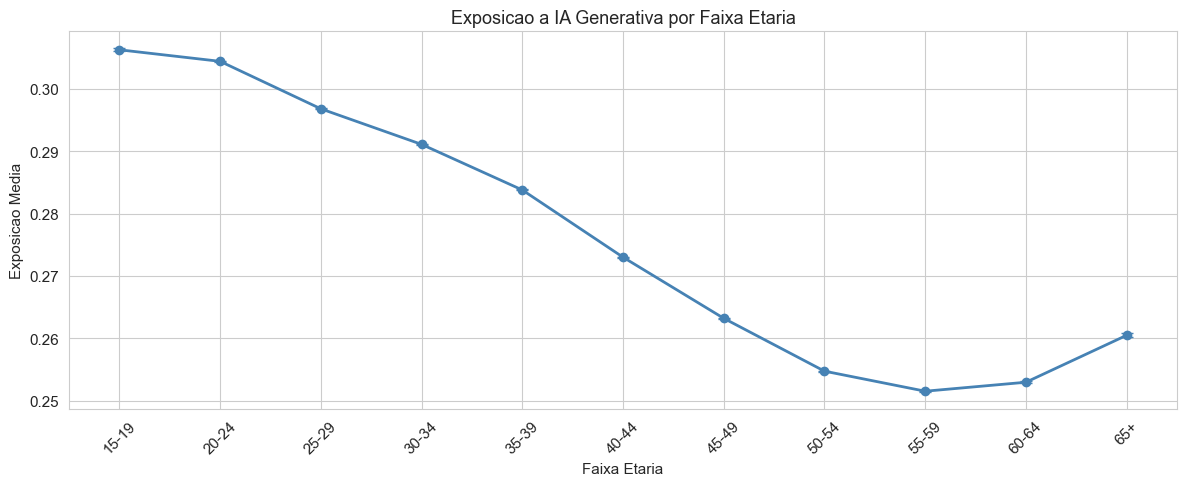


EXPOSICAO POR NIVEL DE INSTRUCAO


,Exp. Media,IC Inf,IC Sup,Pop. (milhoes)
Nivel,,,,
Sem/Fund.Inc.,0.179,0.179,0.179,16.721
Fund.Comp.,0.204,0.204,0.204,6.040
Med.Inc.,0.218,0.218,0.218,5.959
Med.Comp.,0.275,0.275,0.275,37.561
Sup.Inc.,0.359,0.359,0.359,6.464
Sup.Comp.,0.364,0.364,0.364,24.221


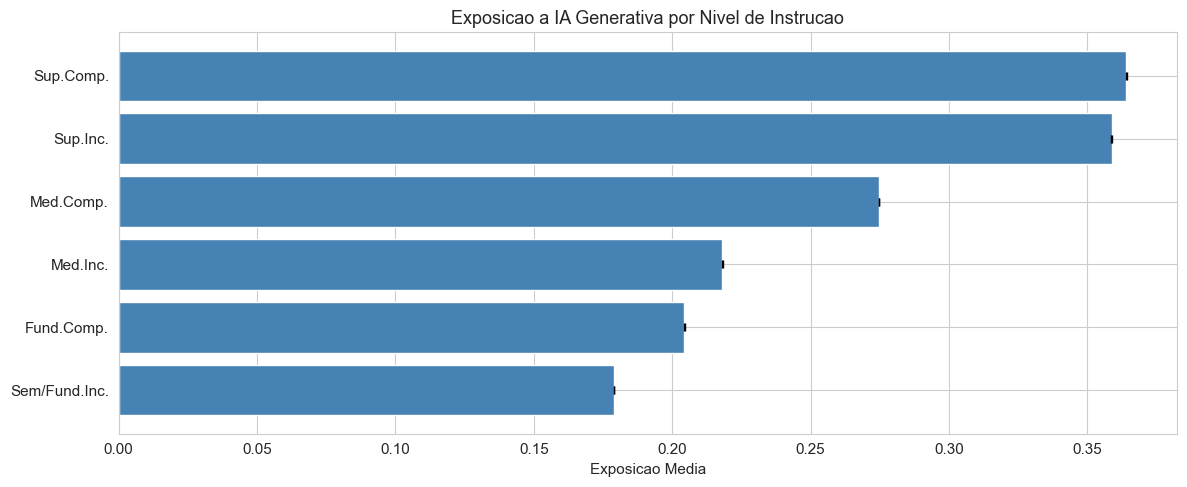

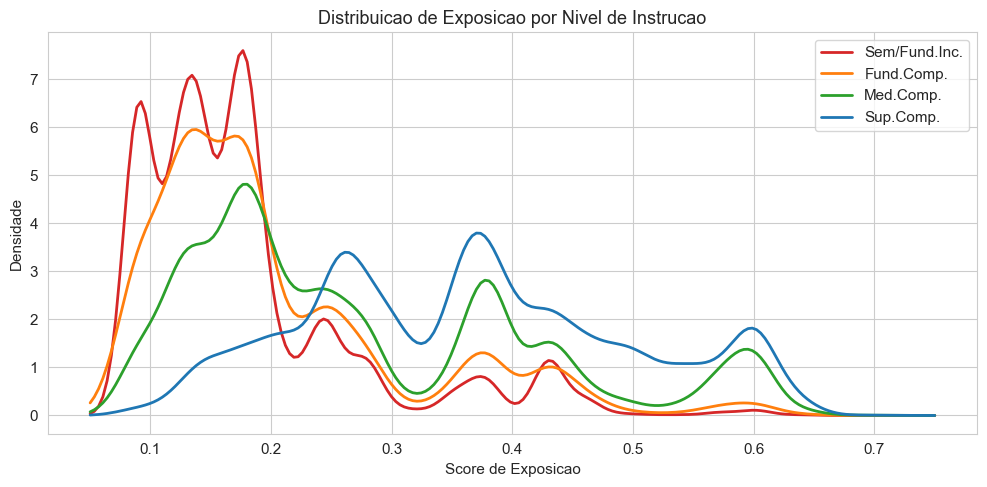


CROSS-TAB: FAIXA ETARIA x EDUCACAO x EXPOSICAO MEDIA


edu_simples,Sem/Fund.Inc.,Fund.Comp.,Med.Comp.,Sup.Comp.
faixa_etaria,,,,
15-19,0.173,0.202,0.333,0.386
20-24,0.181,0.200,0.297,0.383
25-29,0.172,0.190,0.279,0.376
30-34,0.173,0.196,0.270,0.374
35-39,0.174,0.193,0.269,0.368
40-44,0.173,0.199,0.260,0.358
45-49,0.177,0.215,0.257,0.359
50-54,0.180,0.211,0.264,0.347
55-59,0.185,0.215,0.269,0.350


In [69]:
# Etapa 1b.4b - Idade e Escolaridade

# ======================================================================
# 4b.1 - Exposicao por faixa etaria
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR FAIXA ETARIA")
print("=" * 70)

bins_idade = [14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 100]
labels_idade = ['15-19', '20-24', '25-29', '30-34', '35-39',
                '40-44', '45-49', '50-54', '55-59', '60-64', '65+']
df_score['faixa_etaria'] = pd.cut(df_score['idade'], bins=bins_idade, labels=labels_idade)

rows_idade = []
for faixa in labels_idade:
    sub = df_score[df_score['faixa_etaria'] == faixa]
    if len(sub) < 10:
        continue
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    rows_idade.append({
        'Faixa': faixa, 'Exp. Media': mean_e,
        'IC Inf': ci_lo, 'IC Sup': ci_hi,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_idade = pd.DataFrame(rows_idade).set_index('Faixa')
display(tab_idade.round(3))

fig, ax = plt.subplots(figsize=(12, 5))
ax.errorbar(range(len(tab_idade)), tab_idade['Exp. Media'],
            yerr=[tab_idade['Exp. Media']-tab_idade['IC Inf'],
                  tab_idade['IC Sup']-tab_idade['Exp. Media']],
            fmt='o-', capsize=4, color='steelblue', linewidth=2)
ax.set_xticks(range(len(tab_idade)))
ax.set_xticklabels(tab_idade.index, rotation=45)
ax.set_ylabel('Exposicao Media')
ax.set_xlabel('Faixa Etaria')
ax.set_title('Exposicao a IA Generativa por Faixa Etaria')
plt.tight_layout()
plt.show()

# ======================================================================
# 4b.2 - Exposicao por nivel de instrucao
# ======================================================================
print("\n" + "=" * 70)
print("EXPOSICAO POR NIVEL DE INSTRUCAO")
print("=" * 70)

# Usar edu_simples se disponivel, senao nivel_instrucao
edu_col = 'edu_simples' if 'edu_simples' in df_score.columns else 'nivel_instrucao'
rows_edu = []
for edu in df_score[edu_col].dropna().unique():
    sub = df_score[df_score[edu_col] == edu]
    if len(sub) < 10:
        continue
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    rows_edu.append({
        'Nivel': edu, 'Exp. Media': mean_e,
        'IC Inf': ci_lo, 'IC Sup': ci_hi,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_edu = pd.DataFrame(rows_edu).sort_values('Exp. Media').set_index('Nivel')
display(tab_edu.round(3))

fig, ax = plt.subplots(figsize=(12, 5))
tab_edu_plot = tab_edu.sort_values('Exp. Media')
ax.barh(range(len(tab_edu_plot)), tab_edu_plot['Exp. Media'], color='steelblue',
        xerr=[tab_edu_plot['Exp. Media']-tab_edu_plot['IC Inf'],
              tab_edu_plot['IC Sup']-tab_edu_plot['Exp. Media']],
        capsize=3, edgecolor='white')
ax.set_yticks(range(len(tab_edu_plot)))
ax.set_yticklabels(tab_edu_plot.index)
ax.set_xlabel('Exposicao Media')
ax.set_title('Exposicao a IA Generativa por Nivel de Instrucao')
plt.tight_layout()
plt.show()

# ======================================================================
# 4b.3 - KDE sobrepostas por nivel de instrucao
# ======================================================================
if 'edu_simples' in df_score.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    edu_order_kde = ['Sem/Fund.Inc.', 'Fund.Comp.', 'Med.Comp.', 'Sup.Comp.']
    cores_edu = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
    for edu, cor in zip(edu_order_kde, cores_edu):
        sub = df_score[df_score['edu_simples'] == edu]
        if len(sub) < 100:
            continue
        kde = gaussian_kde(sub['exposure_score'].values,
                           weights=sub['peso'].values / sub['peso'].sum())
        x = np.linspace(0.05, 0.75, 200)
        ax.plot(x, kde(x), color=cor, linewidth=2, label=edu)
    ax.set_xlabel('Score de Exposicao')
    ax.set_ylabel('Densidade')
    ax.set_title('Distribuicao de Exposicao por Nivel de Instrucao')
    ax.legend()
    plt.tight_layout()
    plt.show()

# ======================================================================
# 4b.4 - Cross-tab: faixa etaria x nivel de instrucao x exposicao
# ======================================================================
if 'edu_simples' in df_score.columns:
    print("\n" + "=" * 70)
    print("CROSS-TAB: FAIXA ETARIA x EDUCACAO x EXPOSICAO MEDIA")
    print("=" * 70)

    pivot_idade_edu = df_score.groupby(['faixa_etaria', 'edu_simples']).apply(
        lambda x: weighted_mean(x['exposure_score'], x['peso'])
    ).unstack(fill_value=np.nan)

    edu_order_ct = ['Sem/Fund.Inc.', 'Fund.Comp.', 'Med.Comp.', 'Sup.Comp.']
    cols_available = [c for c in edu_order_ct if c in pivot_idade_edu.columns]
    if cols_available:
        pivot_idade_edu = pivot_idade_edu[cols_available]
    display(pivot_idade_edu.round(3))

### 5. Formalidade
% formal por quintil de exposicao; exposicao media no formal vs informal.

**Analises:**
- Exposicao por formalidade com ICs e teste t ponderado
- Investigacao do "paradoxo da formalidade": cross-tab quintil x formalidade x renda + regressao com interacao
- KDE: formal vs informal

> **Interpretação da interação:** O coeficiente da interação
> exposição×formalidade é **negativo** (-1.21, p<0.001). Isso significa que
> o retorno da exposição sobre a renda é MENOR para trabalhadores formais
> do que para informais. Profissionais liberais informais de alta exposição
> (consultores, advogados autônomos, médicos com CNPJ) capturam mais
> retorno da exposição à IA do que empregados formais equivalentes.

> **Contribuição original (formalidade):** A distinção formal/informal
> não aparece no WP140 (irrelevante em países de alta renda onde a
> informalidade é marginal). No Brasil, onde ~57% da força de trabalho
> é informal, essa dimensão é central. A OIT tem interesse particular
> na questão (ILO, 2018 — Women and Men in the Informal Economy) e
> esta análise conecta dois temas prioritários da agenda OIT:
> IA generativa e informalidade.

EXPOSICAO: FORMAL vs INFORMAL
  Formal: Exp=0.305 [IC: 0.305-0.305] | Renda=R$3,216 | Pop=41.4M
  Informal: Exp=0.258 [IC: 0.258-0.259] | Renda=R$3,519 | Pop=55.5M
  Gap (F-I): +0.046 | t=1549.24, p=0.0000 ***


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,Renda Media (R$),Pop. (milhoes)
Tipo,,,,,,
Formal,0.305,0.305,0.305,14.804,3216.103,41.442
Informal,0.258,0.258,0.259,6.555,3518.691,55.525


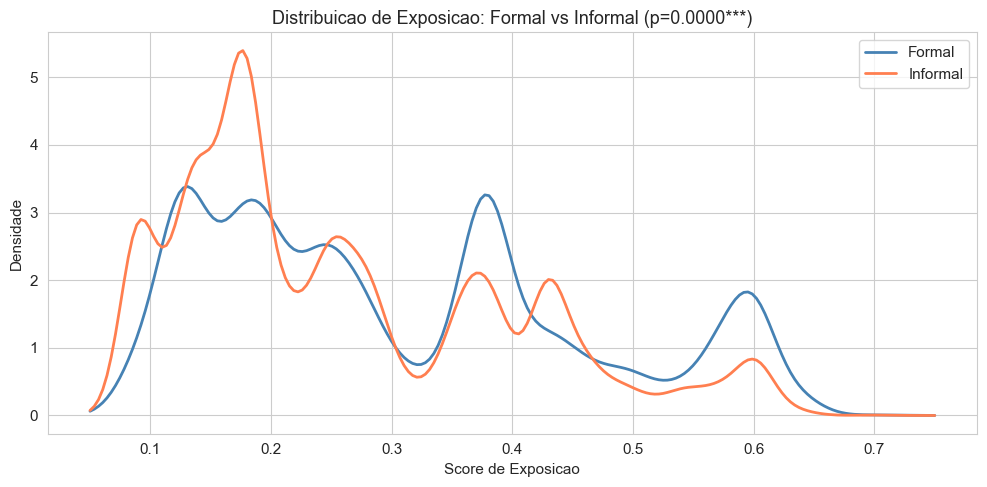


INVESTIGACAO: RENDA POR QUINTIL DE EXPOSICAO E FORMALIDADE


Tipo,Formal,Informal
Quintil,,
Q1 (Baixa),2135.000,1919.000
Q2,2545.000,2394.000
Q3,2972.000,3565.000
Q4,3898.000,6058.000
Q5 (Alta),4058.000,4881.000


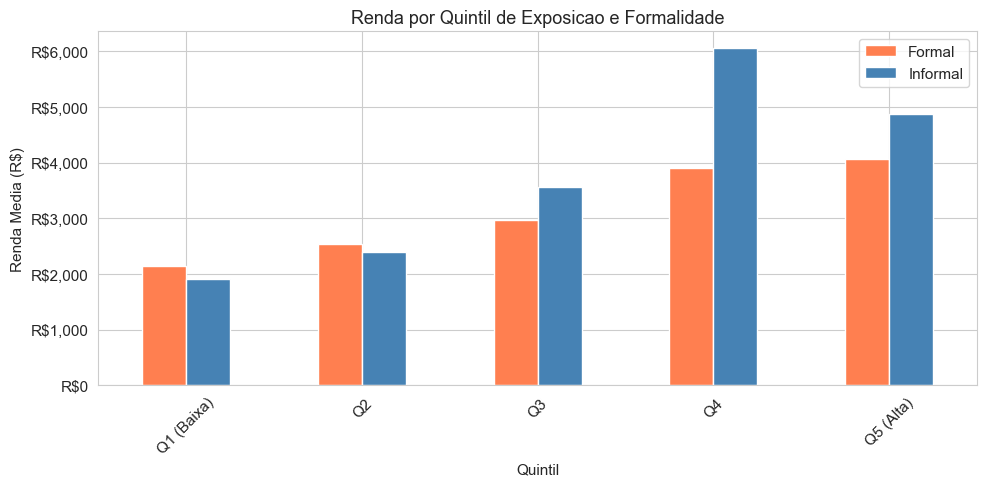


--- Regressao: log(renda) ~ exposicao * formalidade + controles ---

  exposure_score:         +2.1301 (p=0.0000***)
  formal:                 +0.4471 (p=0.0000***)
  exposure_score:formal:  -1.2137 (p=0.0000***)
  R²: 0.2485 | N: 202,471

  Interpretacao: A interacao exposicao:formal e significativa
  (coef = -1.2137, p<0.001).
  O retorno da exposicao sobre a renda e MENOR para trabalhadores
  formais do que para informais.
  Trabalhadores informais de alta exposicao capturam mais retorno,
  possivelmente refletindo profissionais liberais autonomos (consultores,
  advogados, medicos com CNPJ) que operam na informalidade mas em
  ocupacoes de alta qualificacao e alta exposicao a IA.


In [70]:
# Etapa 1b.5 - Analise de Dados - Formalidade

# ======================================================================
# 5.1 - Exposicao por formalidade com ICs e teste t
# ======================================================================
print("=" * 70)
print("EXPOSICAO: FORMAL vs INFORMAL")
print("=" * 70)

rows_formal = []
for val, label in [(1, 'Formal'), (0, 'Informal')]:
    sub = df_score[df_score['formal'] == val]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    sub_r = sub[sub['tem_renda'] == 1]
    mean_renda = weighted_mean(sub_r['rendimento_habitual'], sub_r['peso']) if len(sub_r) > 0 else np.nan
    rows_formal.append({
        'Tipo': label,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Renda Media (R$)': mean_renda,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {label}: Exp={mean_e:.3f} [IC: {ci_lo:.3f}-{ci_hi:.3f}] | "
          f"Renda=R${mean_renda:,.0f} | Pop={sub['peso'].sum()/1e6:.1f}M")

# Teste t
sub_f = df_score[df_score['formal'] == 1]
sub_i = df_score[df_score['formal'] == 0]
t_form, p_form = weighted_ttest_2groups(
    sub_f['exposure_score'], sub_f['peso'],
    sub_i['exposure_score'], sub_i['peso']
)
print(f"  Gap (F-I): {rows_formal[0]['Exp. Media']-rows_formal[1]['Exp. Media']:+.3f} | "
      f"t={t_form:.2f}, p={p_form:.4f} {sig_stars(p_form)}")

tab_formal = pd.DataFrame(rows_formal).set_index('Tipo')
display(tab_formal.round(3))

# ======================================================================
# 5.2 - KDE formal vs informal
# ======================================================================
fig, ax = plt.subplots(figsize=(10, 5))
for val, label, cor in [(1, 'Formal', 'steelblue'), (0, 'Informal', 'coral')]:
    sub = df_score[df_score['formal'] == val]
    kde = gaussian_kde(sub['exposure_score'].values,
                      weights=sub['peso'].values / sub['peso'].sum())
    x = np.linspace(0.05, 0.75, 200)
    ax.plot(x, kde(x), color=cor, linewidth=2, label=label)
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Densidade')
ax.set_title(f'Distribuicao de Exposicao: Formal vs Informal (p={p_form:.4f}{sig_stars(p_form)})')
ax.legend()
plt.tight_layout()
plt.show()

# ======================================================================
# 5.3 - Investigacao do "paradoxo": quintil x formalidade x renda
# ======================================================================
print("\n" + "=" * 70)
print("INVESTIGACAO: RENDA POR QUINTIL DE EXPOSICAO E FORMALIDADE")
print("=" * 70)

rows_qf = []
for q in QUINTIL_ORDER:
    for val, label in [(1, 'Formal'), (0, 'Informal')]:
        sub = df_renda[(df_renda['quintil_exposure'] == q) & (df_renda['formal'] == val)]
        if len(sub) < 10:
            continue
        mean_r = weighted_mean(sub['rendimento_habitual'], sub['peso'])
        rows_qf.append({
            'Quintil': q, 'Tipo': label, 'Renda Media': mean_r,
            'Pop (milhoes)': sub['peso'].sum()/1e6,
        })

tab_qf = pd.DataFrame(rows_qf)
tab_qf_pivot = tab_qf.pivot(index='Quintil', columns='Tipo', values='Renda Media')
display(tab_qf_pivot.round(0))

# Grafico
fig, ax = plt.subplots(figsize=(10, 5))
tab_qf_pivot.plot(kind='bar', ax=ax, color=['coral', 'steelblue'], edgecolor='white')
ax.set_ylabel('Renda Media (R$)')
ax.set_title('Renda por Quintil de Exposicao e Formalidade')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
ax.tick_params(axis='x', rotation=45)
ax.legend(title='')
plt.tight_layout()
plt.show()

# ======================================================================
# 5.4 - Regressao com interacao exposicao x formalidade
# ======================================================================
print("\n--- Regressao: log(renda) ~ exposicao * formalidade + controles ---")

df_reg_formal = df_renda[['rendimento_habitual', 'exposure_score', 'formal',
                            'sexo_texto', 'raca_agregada', 'idade', 'regiao']].dropna().copy()
df_reg_formal['log_renda'] = np.log(df_reg_formal['rendimento_habitual'].clip(lower=1))

model_formal = smf.wls(
    'log_renda ~ exposure_score * formal + C(sexo_texto) + C(raca_agregada) + idade + I(idade**2) + C(regiao)',
    data=df_reg_formal,
    weights=df_renda.loc[df_reg_formal.index, 'peso']
).fit(cov_type='HC1')

print(f"\n  exposure_score:         {model_formal.params['exposure_score']:+.4f} "
      f"(p={model_formal.pvalues['exposure_score']:.4f}{sig_stars(model_formal.pvalues['exposure_score'])})")
print(f"  formal:                 {model_formal.params['formal']:+.4f} "
      f"(p={model_formal.pvalues['formal']:.4f}{sig_stars(model_formal.pvalues['formal'])})")
print(f"  exposure_score:formal:  {model_formal.params['exposure_score:formal']:+.4f} "
      f"(p={model_formal.pvalues['exposure_score:formal']:.4f}{sig_stars(model_formal.pvalues['exposure_score:formal'])})")
print(f"  R²: {model_formal.rsquared:.4f} | N: {int(model_formal.nobs):,}")

coef_interacao = model_formal.params['exposure_score:formal']
direcao = "MENOR" if coef_interacao < 0 else "MAIOR"
beneficiario = "informais" if coef_interacao < 0 else "formais"

print(f"\n  Interpretacao: A interacao exposicao:formal e significativa")
print(f"  (coef = {coef_interacao:.4f}, p<0.001).")
print(f"  O retorno da exposicao sobre a renda e {direcao} para trabalhadores")
print(f"  formais do que para informais.")
print(f"  Trabalhadores {beneficiario} de alta exposicao capturam mais retorno,")
print(f"  possivelmente refletindo profissionais liberais autonomos (consultores,")
print(f"  advogados, medicos com CNPJ) que operam na informalidade mas em")
print(f"  ocupacoes de alta qualificacao e alta exposicao a IA.")

### 5b. Augmentation vs. Automacao
Comparacao entre trabalhadores em gradientes de complementaridade (G1-G2)
e de transformacao radical (G3-G4), seguindo a distincao central do WP140.

**Analises:**
- Perfil comparativo: renda, genero, raca, escolaridade, formalidade, setor
- Grafico de barras agrupadas lado a lado
- Testes de diferenca entre os dois grupos

> **Referencia WP140:** "The results suggest that most occupations and
> industries are more likely to be transformed through augmentation rather
> than automation" (Gmyrek et al., 2025, p.1). Esta secao investiga se
> esse padrao se confirma para o Brasil.

AUGMENTATION vs. ALTA TRANSFORMACAO


,Pop. (milhoes),Exp. Media,Renda Media,% Mulheres,% Formal,% Sup. Completo
Tipo,,,,,,
Augmentation (G1-G2),18.700,0.400,4179.200,47.100,44.000,31.900
Alta Transformacao (G3-G4),9.800,0.600,3793.100,62.900,62.800,44.300


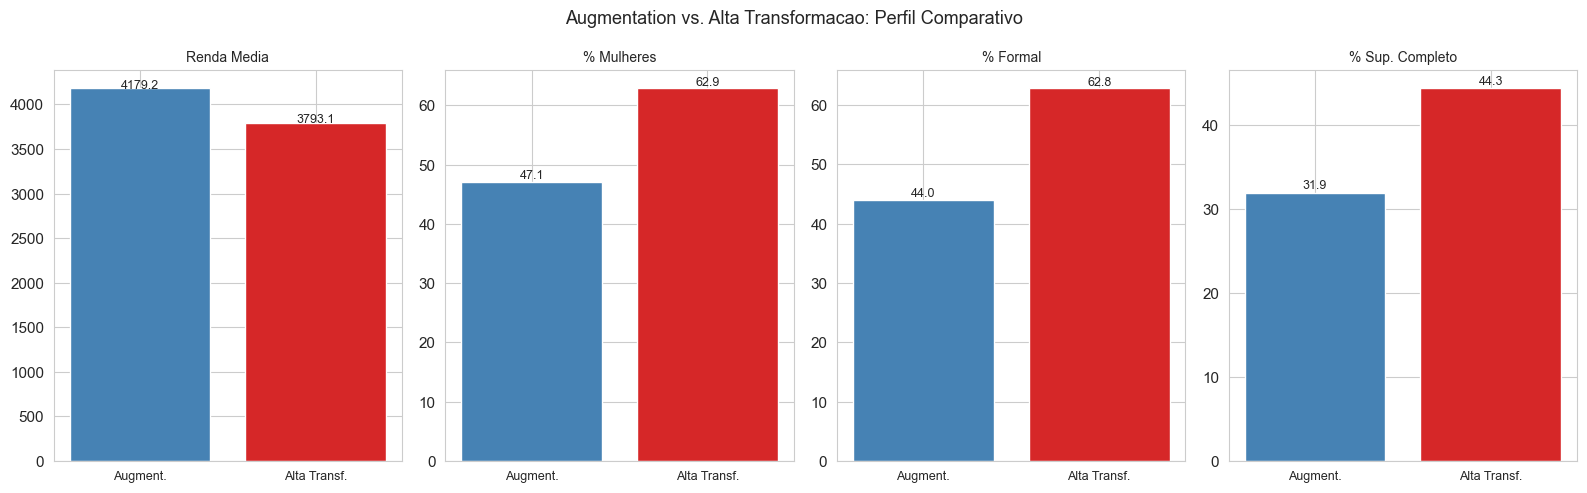


Diferenca de renda (Aug vs HT): t=181.00, p=0.0000 ***
d de Cohen: 0.072


In [71]:
# Etapa 1b.5b - Augmentation vs. Automacao

AUGMENTATION = ['Exposed: Gradient 1', 'Exposed: Gradient 2']
HIGH_TRANSFORM = ['Exposed: Gradient 3', 'Exposed: Gradient 4']

df_score['tipo_exposicao'] = np.where(
    df_score['exposure_gradient'].isin(AUGMENTATION), 'Augmentation (G1-G2)',
    np.where(df_score['exposure_gradient'].isin(HIGH_TRANSFORM), 'Alta Transformacao (G3-G4)',
    'Nao/Minima Exposicao'))

# Apenas os dois grupos de interesse
df_aug = df_score[df_score['tipo_exposicao'].isin(
    ['Augmentation (G1-G2)', 'Alta Transformacao (G3-G4)'])]

print("=" * 70)
print("AUGMENTATION vs. ALTA TRANSFORMACAO")
print("=" * 70)

rows_tipo = []
for tipo in ['Augmentation (G1-G2)', 'Alta Transformacao (G3-G4)']:
    sub = df_aug[df_aug['tipo_exposicao'] == tipo]
    sub_r = sub[sub['tem_renda'] == 1]
    rows_tipo.append({
        'Tipo': tipo,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
        'Exp. Media': weighted_mean(sub['exposure_score'], sub['peso']),
        'Renda Media': weighted_mean(sub_r['rendimento_habitual'], sub_r['peso']) if len(sub_r) > 0 else np.nan,
        '% Mulheres': weighted_mean((sub['sexo_texto']=='Mulher').astype(int), sub['peso'])*100,
        '% Formal': weighted_mean(sub['formal'], sub['peso'])*100,
        '% Sup. Completo': weighted_mean(
            (sub['edu_simples']=='Sup.Comp.').astype(int), sub['peso'])*100 if 'edu_simples' in sub.columns else np.nan,
    })

tab_tipo = pd.DataFrame(rows_tipo).set_index('Tipo')
display(tab_tipo.round(1))

# Grafico de barras agrupadas
metricas = ['Renda Media', '% Mulheres', '% Formal', '% Sup. Completo']
fig, axes = plt.subplots(1, len(metricas), figsize=(16, 5))
for ax, met in zip(axes, metricas):
    vals = [tab_tipo.loc[t, met] for t in tab_tipo.index]
    bars = ax.bar(range(len(vals)), vals, color=['steelblue', '#d62728'])
    ax.set_xticks(range(len(vals)))
    ax.set_xticklabels(['Augment.', 'Alta Transf.'], fontsize=9)
    ax.set_title(met, fontsize=10)
    for b, v in zip(bars, vals):
        if not np.isnan(v):
            ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.5,
                    f'{v:.1f}', ha='center', fontsize=9)
plt.suptitle('Augmentation vs. Alta Transformacao: Perfil Comparativo', fontsize=13)
plt.tight_layout()
plt.show()

# Teste de diferenca
sub_aug = df_aug[df_aug['tipo_exposicao'] == 'Augmentation (G1-G2)']
sub_ht = df_aug[df_aug['tipo_exposicao'] == 'Alta Transformacao (G3-G4)']
sub_aug_r = sub_aug[sub_aug['tem_renda'] == 1]
sub_ht_r = sub_ht[sub_ht['tem_renda'] == 1]

if len(sub_aug_r) > 10 and len(sub_ht_r) > 10:
    t_aug, p_aug = weighted_ttest_2groups(
        sub_aug_r['rendimento_habitual'], sub_aug_r['peso'],
        sub_ht_r['rendimento_habitual'], sub_ht_r['peso'])
    d_aug = weighted_cohen_d(
        sub_aug_r['rendimento_habitual'].values, sub_aug_r['peso'].values,
        sub_ht_r['rendimento_habitual'].values, sub_ht_r['peso'].values)
    print(f"\nDiferenca de renda (Aug vs HT): t={t_aug:.2f}, p={p_aug:.4f} {sig_stars(p_aug)}")
    print(f"d de Cohen: {d_aug:.3f}")

### 6. Setor e ocupacao
Exposicao media por setor_agregado e por grande_grupo; concentracao em setores criticos IA.

**Analises:**
- Exposicao por setor com ICs e ANOVA ponderada
- Exposicao por grupo ocupacional com ICs e ANOVA ponderada
- Educacao DENTRO de grupos ocupacionais (cross-tab)
- Heatmap regiao x setor

> **Nota metodológica:** O R² elevado da ANOVA por grupo ocupacional
> (≈0.68) é em grande parte um artefato da construção do índice ILO,
> que atribui scores por ocupação ISCO a 4 dígitos. Como os grandes
> grupos são agrupamentos a 1 dígito dessas ocupações, a alta explicação
> é esperada e não constitui um achado empírico.
>
> A variação de exposição DENTRO dos grupos, observada na cross-tab com
> educação, é mínima — confirmando que o índice é uma propriedade da
> ocupação, não do indivíduo. A correlação exposição-escolaridade no
> nível individual opera via sorting: trabalhadores mais educados acessam
> ocupações de maior exposição.

> **Conexão com WP140 (Tabela 2):** O ranking ocupacional brasileiro replica
> a hierarquia global do WP140: Clerical Support Workers (Apoio
> Administrativo) é o grupo mais exposto, seguido de Professionals e
> Managers. Elementary Occupations está na base. A única diferença
> notável é que no Brasil, "Serviços e Vendedores" tem exposição
> relativamente alta (0.305 vs ~0.25 global), possivelmente pela
> estrutura do comércio brasileiro que incorpora mais tarefas
> administrativas/digitais nas funções de venda.

EXPOSICAO POR SETOR ECONOMICO


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,Pop. (milhoes),Critico IA
Setor,,,,,,
Finanças e Seguros,0.509,0.509,0.509,53.496,1.566,
Informação e Comunicação,0.445,0.445,0.445,30.028,1.891,
Serviços Profissionais,0.409,0.409,0.410,29.587,4.322,
Atividades Imobiliárias,0.384,0.384,0.384,17.071,0.727,
Administração Pública,0.352,0.352,0.352,26.280,4.274,
Outros Serviços,0.331,0.331,0.331,7.279,19.114,
Artes e Cultura,0.317,0.316,0.317,9.281,1.153,
Saúde,0.300,0.300,0.300,13.714,6.196,
Utilidades,0.293,0.293,0.294,15.105,0.727,



ANOVA ponderada (setores): F=5031.9, p=0.00e+00 ***
R²: 0.2808 (variacao explicada pelos setores)


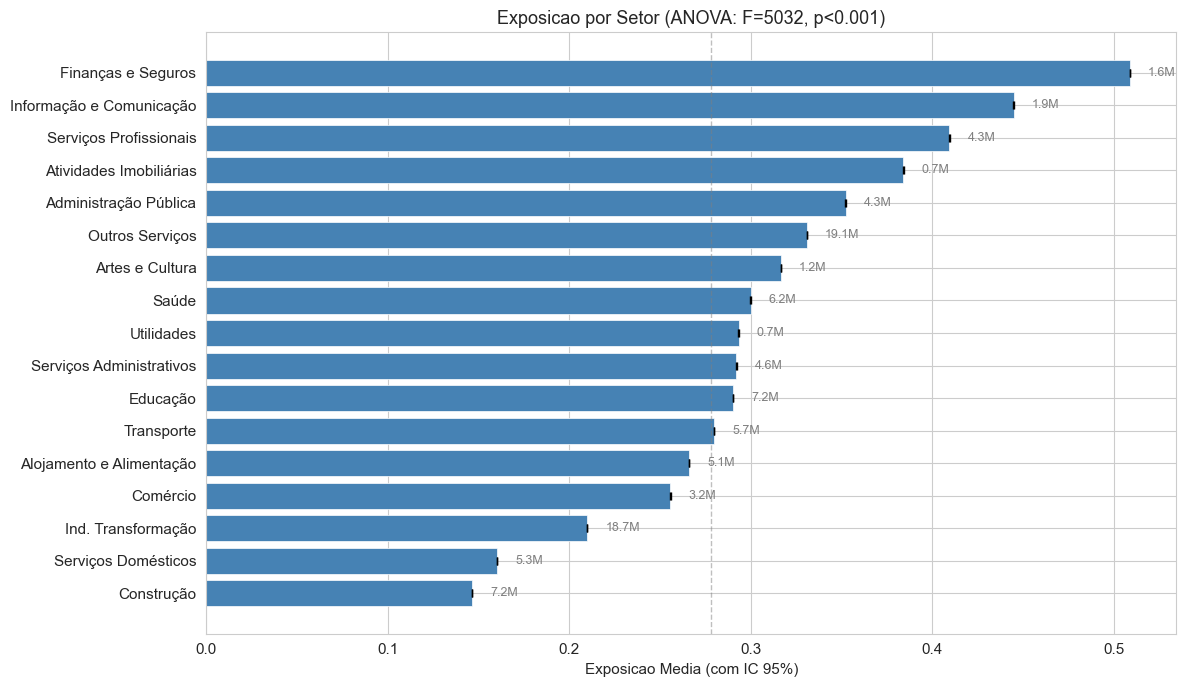


EXPOSICAO POR GRANDE GRUPO OCUPACIONAL


,Exp. Media,IC Inf,IC Sup,Pop. (milhoes)
Grande Grupo,,,,
Apoio administrativo,0.554,0.554,0.554,8.197
Dirigentes e gerentes,0.400,0.400,0.400,3.543
Profissionais das ciências,0.353,0.353,0.354,13.239
Técnicos nível médio,0.345,0.345,0.345,8.990
Serviços e vendedores,0.305,0.305,0.305,21.275
Operadores de máquinas,0.223,0.223,0.223,9.427
Agropecuária qualificada,0.174,0.174,0.174,4.442
Indústria qualificada,0.151,0.151,0.151,12.711
Ocupações elementares,0.130,0.130,0.130,15.144



ANOVA ponderada (grupos): F=53767.9, p=0.00e+00 ***
R²: 0.6759

EXPOSICAO MEDIA POR EDUCACAO DENTRO DE CADA GRUPO OCUPACIONAL


edu_simples,Sem/Fund.Inc.,Fund.Comp.,Med.Inc.,Med.Comp.,Sup.Inc.,Sup.Comp.
grande_grupo,,,,,,
Agropecuária qualificada,0.174,0.174,0.173,0.175,0.176,0.176
Apoio administrativo,0.497,0.494,0.505,0.542,0.569,0.582
Dirigentes e gerentes,0.373,0.388,0.385,0.401,0.404,0.401
Indústria qualificada,0.131,0.143,0.147,0.159,0.175,0.181
Ocupações elementares,0.125,0.128,0.128,0.136,0.144,0.137
Operadores de máquinas,0.209,0.219,0.219,0.226,0.240,0.238
Profissionais das ciências,0.316,0.343,0.379,0.371,0.368,0.352
Serviços e vendedores,0.293,0.292,0.293,0.306,0.312,0.321
Técnicos nível médio,0.354,0.359,0.368,0.321,0.354,0.366



Interpretacao: Dentro do mesmo grupo ocupacional, a exposicao
tende a ser similar independente da escolaridade, pois o indice
e atribuido por ocupacao (ISCO-08), nao por individuo.

  ⚠ Setores criticos sem match no df: ['Informacao e Comunicacao', 'Financas e Seguros', 'Servicos Profissionais']
  Setores disponiveis no df: ['Administração Pública', 'Alojamento e Alimentação', 'Artes e Cultura', 'Atividades Imobiliárias', 'Comércio', 'Construção', 'Educação', 'Finanças e Seguros', 'Ind. Transformação', 'Informação e Comunicação', 'Outros Serviços', 'Saúde', 'Serviços Administrativos', 'Serviços Domésticos', 'Serviços Profissionais', 'Transporte', 'Utilidades']


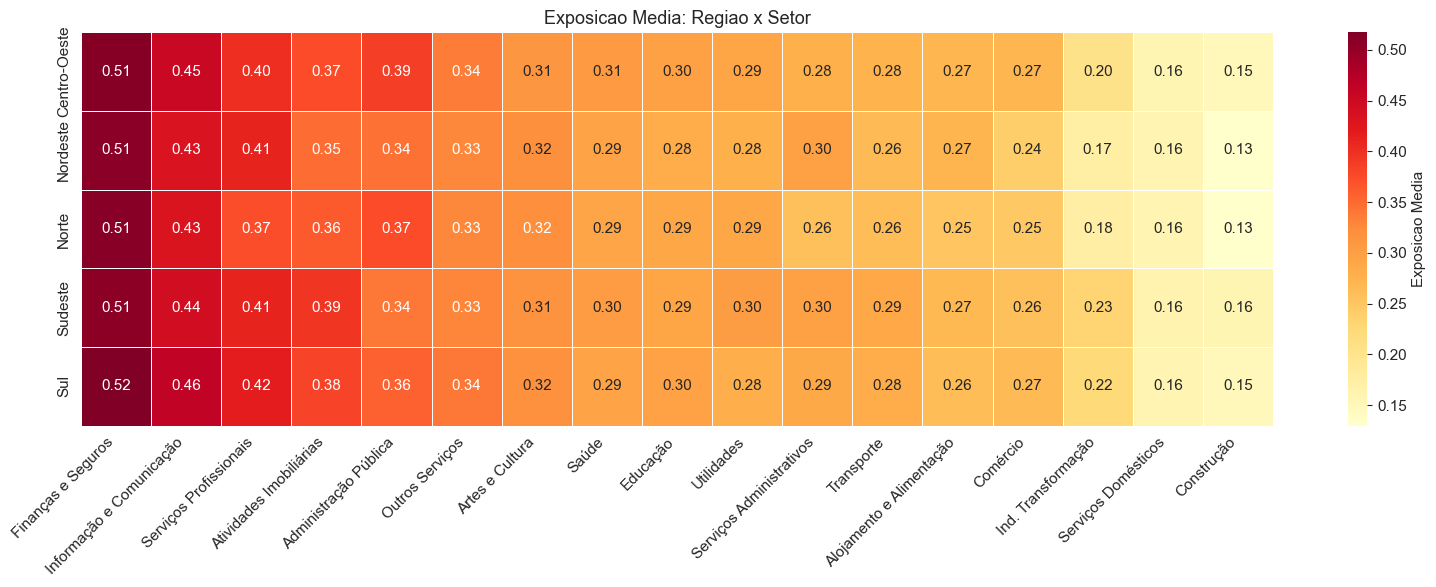

In [72]:
# Etapa 1b.6 - Analise de Dados - Setor e ocupacao

# ======================================================================
# 6.1 - Exposicao por setor com ICs e ANOVA
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR SETOR ECONOMICO")
print("=" * 70)

rows_setor = []
for setor in sorted(df_score['setor_agregado'].unique()):
    sub = df_score[df_score['setor_agregado'] == setor]
    if len(sub) < 10:
        continue
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    is_critico = setor in SETORES_CRITICOS_IA
    rows_setor.append({
        'Setor': setor,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
        'Critico IA': '*' if is_critico else '',
    })

tab_setor = pd.DataFrame(rows_setor).sort_values('Exp. Media', ascending=False).set_index('Setor')
display(tab_setor.round(3))

# ANOVA ponderada via WLS
model_anova_setor = smf.wls(
    'exposure_score ~ C(setor_agregado)',
    data=df_score, weights=df_score['peso']
).fit()
f_stat = model_anova_setor.fvalue
f_pval = model_anova_setor.f_pvalue
print(f"\nANOVA ponderada (setores): F={f_stat:.1f}, p={f_pval:.2e} {sig_stars(f_pval)}")
print(f"R²: {model_anova_setor.rsquared:.4f} (variacao explicada pelos setores)")

# Grafico setores
fig, ax = plt.subplots(figsize=(12, 7))
tab_plot = tab_setor.reset_index().sort_values('Exp. Media')
colors = ['#d62728' if c == '*' else 'steelblue' for c in tab_plot['Critico IA']]
yerr = [tab_plot['Exp. Media'] - tab_plot['IC Inf'], tab_plot['IC Sup'] - tab_plot['Exp. Media']]
ax.barh(tab_plot['Setor'], tab_plot['Exp. Media'], xerr=yerr, color=colors,
        edgecolor='white', linewidth=0.5, capsize=3)
for i, (_, row) in enumerate(tab_plot.iterrows()):
    ax.text(row['Exp. Media'] + 0.01, i, f"{row['Pop. (milhoes)']:.1f}M",
            va='center', fontsize=9, color='gray')
ax.set_xlabel('Exposicao Media (com IC 95%)')
ax.set_title(f'Exposicao por Setor (ANOVA: F={f_stat:.0f}, p<0.001)')
ax.axvline(weighted_mean(df_score['exposure_score'], df_score['peso']),
           color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

# ======================================================================
# 6.2 - Exposicao por grupo ocupacional com ICs e ANOVA
# ======================================================================
print("\n" + "=" * 70)
print("EXPOSICAO POR GRANDE GRUPO OCUPACIONAL")
print("=" * 70)

df_gg = df_score[df_score['grande_grupo'].notna()]
rows_grupo = []
for grupo in sorted(df_gg['grande_grupo'].unique()):
    sub = df_gg[df_gg['grande_grupo'] == grupo]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    rows_grupo.append({
        'Grande Grupo': grupo,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_grupo = pd.DataFrame(rows_grupo).sort_values('Exp. Media', ascending=False).set_index('Grande Grupo')
display(tab_grupo.round(3))

model_anova_grupo = smf.wls(
    'exposure_score ~ C(grande_grupo)',
    data=df_gg, weights=df_gg['peso']
).fit()
print(f"\nANOVA ponderada (grupos): F={model_anova_grupo.fvalue:.1f}, "
      f"p={model_anova_grupo.f_pvalue:.2e} {sig_stars(model_anova_grupo.f_pvalue)}")
print(f"R²: {model_anova_grupo.rsquared:.4f}")

# ======================================================================
# 6.3 - Educacao DENTRO de grupos ocupacionais
# ======================================================================
print("\n" + "=" * 70)
print("EXPOSICAO MEDIA POR EDUCACAO DENTRO DE CADA GRUPO OCUPACIONAL")
print("=" * 70)

df_edu_gg = df_gg.copy()
# Usar niveis de instrucao simplificados para legibilidade
edu_map_simples = {
    '1': 'Sem/Fund.Inc.', '2': 'Sem/Fund.Inc.',
    '3': 'Fund.Comp.', '4': 'Med.Inc.',
    '5': 'Med.Comp.', '6': 'Sup.Inc.', '7': 'Sup.Comp.',
}
df_edu_gg['edu_simples'] = df_edu_gg['nivel_instrucao'].astype(str).map(edu_map_simples)

pivot_edu = df_edu_gg.groupby(['grande_grupo', 'edu_simples']).apply(
    lambda x: weighted_mean(x['exposure_score'], x['peso'])
).unstack(fill_value=np.nan)

# Reordenar colunas
edu_order = ['Sem/Fund.Inc.', 'Fund.Comp.', 'Med.Inc.', 'Med.Comp.', 'Sup.Inc.', 'Sup.Comp.']
cols_available = [c for c in edu_order if c in pivot_edu.columns]
pivot_edu = pivot_edu[cols_available]

display(pivot_edu.round(3))

print("\nInterpretacao: Dentro do mesmo grupo ocupacional, a exposicao")
print("tende a ser similar independente da escolaridade, pois o indice")
print("e atribuido por ocupacao (ISCO-08), nao por individuo.")

# Verificar matching dos setores criticos
setores_no_df = sorted(df_score['setor_agregado'].unique())
matched_setores = [s for s in SETORES_CRITICOS_IA if s in setores_no_df]
if len(matched_setores) < len(SETORES_CRITICOS_IA):
    unmatched = [s for s in SETORES_CRITICOS_IA if s not in setores_no_df]
    print(f"\n  \u26a0 Setores criticos sem match no df: {unmatched}")
    print(f"  Setores disponiveis no df: {setores_no_df}")
else:
    print(f"\n  Setores criticos IA: todos {len(matched_setores)} encontrados no dataframe.")

# ======================================================================
# 6.4 - Heatmap regiao x setor
# ======================================================================
pivot_rs = df_score.groupby(['regiao', 'setor_agregado']).apply(
    lambda x: weighted_mean(x['exposure_score'], x['peso'])
).unstack(fill_value=np.nan)

# Ordenar setores por media
setor_order = pivot_rs.mean().sort_values(ascending=False).index
pivot_rs = pivot_rs[setor_order]

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot_rs, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, linecolor='white', cbar_kws={'label': 'Exposicao Media'})
ax.set_title('Exposicao Media: Regiao x Setor')
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6b. Fluxo: Escolaridade -> Ocupacao -> Gradiente de Exposicao
Diagrama de fluxo mostrando o sorting educacao -> ocupacao -> exposicao.

In [73]:
# Etapa 1b.6b - Sankey: Escolaridade -> Grupo Ocupacional -> Gradiente

# ======================================================================
# 6b - Sankey: Escolaridade -> Grupo Ocupacional -> Gradiente
# ======================================================================

# Garantir edu_simples em df_score
if 'edu_simples' not in df_score.columns:
    edu_map_simples = {'1': 'Sem/Fund.Inc.', '2': 'Sem/Fund.Inc.', '3': 'Fund.Comp.', '4': 'Med.Inc.', '5': 'Med.Comp.', '6': 'Sup.Inc.', '7': 'Sup.Comp.'}
    col_edu = 'nivel_instrucao' if 'nivel_instrucao' in df_score.columns else 'vd3004'
    df_score['edu_simples'] = df_score[col_edu].astype(str).map(edu_map_simples).fillna('Outros')

# Agregar fluxos
flows = df_score.groupby(['edu_simples', 'grande_grupo', 'exposure_gradient'])['peso'].sum().reset_index()
flows = flows[flows['peso'] > 500000]  # filtrar fluxos pequenos

# Usar plotly para Sankey
try:
    import plotly.graph_objects as go

    # Construir nos e links
    edu_cats = sorted(flows['edu_simples'].unique())
    gg_cats = sorted(flows['grande_grupo'].unique())
    grad_cats = [g for g in GRADIENT_ORDER if g in flows['exposure_gradient'].unique()]
    all_nodes = list(edu_cats) + list(gg_cats) + list(grad_cats)

    sources, targets, values = [], [], []
    # Edu -> GG
    for _, row in flows.groupby(['edu_simples', 'grande_grupo'])['peso'].sum().reset_index().iterrows():
        sources.append(all_nodes.index(row['edu_simples']))
        targets.append(all_nodes.index(row['grande_grupo']))
        values.append(row['peso'] / 1e6)
    # GG -> Gradiente
    for _, row in flows.groupby(['grande_grupo', 'exposure_gradient'])['peso'].sum().reset_index().iterrows():
        sources.append(all_nodes.index(row['grande_grupo']))
        targets.append(all_nodes.index(row['exposure_gradient']))
        values.append(row['peso'] / 1e6)

    fig = go.Figure(go.Sankey(
        node=dict(label=all_nodes, pad=15, thickness=20),
        link=dict(source=sources, target=targets, value=values)))
    fig.update_layout(title='Fluxo: Escolaridade -> Ocupacao -> Gradiente de Exposicao',
                      font_size=10, width=1200, height=700)
    fig.show()
except ImportError:
    print("plotly nao instalado. Instalar com: %pip install plotly")

plotly nao instalado. Instalar com: %pip install plotly


### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

> **Conexão com WP140 (dimensão geográfica):** O WP140 analisa variação
> entre países (Figura 6, p. 22-23) e encontra que países de maior
> renda per capita têm maior exposição, refletindo sua estrutura
> produtiva mais intensiva em serviços. Replicamos esse padrão DENTRO
> do Brasil: regiões de maior PIB per capita (Sudeste, Sul,
> Centro-Oeste) apresentam maior exposição. O DF (0.326) supera
> inclusive a média de high-income countries (~0.36 no WP140), refletindo
> a concentração de serviços públicos e profissionais qualificados.

EXPOSICAO POR REGIAO
  Norte: 0.258 [IC: 0.258-0.258] | Alta: 8.4% | Pop: 7.7M
  Nordeste: 0.261 [IC: 0.261-0.261] | Alta: 8.0% | Pop: 22.2M
  Centro-Oeste: 0.282 [IC: 0.282-0.282] | Alta: 10.7% | Pop: 8.4M
  Sudeste: 0.289 [IC: 0.289-0.289] | Alta: 11.2% | Pop: 43.1M
  Sul: 0.282 [IC: 0.282-0.282] | Alta: 10.5% | Pop: 15.7M


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,% Nao Exposto,Pop. (milhoes)
Regiao,,,,,,
Norte,0.258,0.258,0.258,8.376,59.352,7.722
Nordeste,0.261,0.261,0.261,8.020,58.641,22.152
Centro-Oeste,0.282,0.282,0.282,10.712,53.201,8.353
Sudeste,0.289,0.289,0.289,11.171,50.751,43.088
Sul,0.282,0.282,0.282,10.502,53.312,15.652



ANOVA ponderada (regioes): F=373.9, p=1.89e-321 ***
R²: 0.0072 (pouca variacao explicada apenas por regiao)


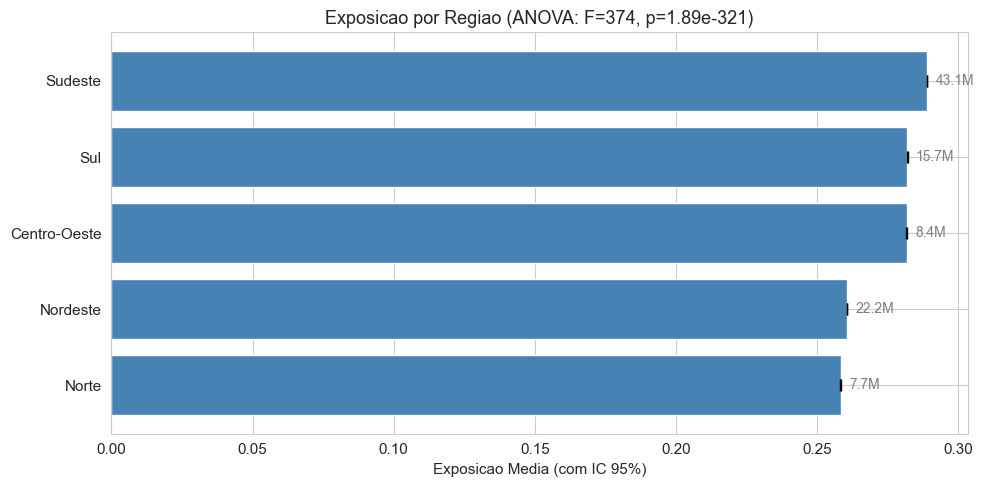


RANKING ESTADUAL DE EXPOSICAO


,Regiao,Exp. Media,IC Inf,IC Sup,Pop. (milhoes)
UF,,,,,
DF,Centro-Oeste,0.326,0.326,0.326,1.434
RJ,Sudeste,0.301,0.300,0.301,7.663
SP,Sudeste,0.297,0.297,0.297,23.175
SC,Sul,0.283,0.283,0.283,4.278
RR,Norte,0.282,0.282,0.283,0.270
PR,Sul,0.282,0.282,0.282,5.925
RS,Sul,0.281,0.281,0.281,5.449
GO,Centro-Oeste,0.275,0.275,0.276,3.659
AP,Norte,0.275,0.274,0.275,0.325



Top 5 UFs (maior exposicao):
  DF (Centro-Oeste): 0.326
  RJ (Sudeste): 0.301
  SP (Sudeste): 0.297
  SC (Sul): 0.283
  RR (Norte): 0.282

Bottom 5 UFs (menor exposicao):
  RO (Norte): 0.256
  MA (Nordeste): 0.255
  BA (Nordeste): 0.254
  PI (Nordeste): 0.253
  PA (Norte): 0.248

Nota: Mapas coropletas detalhados foram gerados pelo script 09
(etapa1_ia_generativa/outputs/figures/mapa_c*.png)


In [74]:
# Etapa 1b.7 - Analise de Dados - Regiao

# ======================================================================
# 7.1 - Exposicao por regiao com ICs e ANOVA
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR REGIAO")
print("=" * 70)

rows_regiao = []
for regiao in ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']:
    sub = df_score[df_score['regiao'] == regiao]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    n_nao = sub[sub['exposure_gradient'] == 'Not Exposed']['peso'].sum()
    rows_regiao.append({
        'Regiao': regiao,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        '% Nao Exposto': n_nao / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {regiao}: {mean_e:.3f} [IC: {ci_lo:.3f}-{ci_hi:.3f}] | "
          f"Alta: {n_alta/sub['peso'].sum()*100:.1f}% | Pop: {sub['peso'].sum()/1e6:.1f}M")

tab_regiao = pd.DataFrame(rows_regiao).set_index('Regiao')
display(tab_regiao.round(3))

# ANOVA
model_anova_reg = smf.wls(
    'exposure_score ~ C(regiao)',
    data=df_score, weights=df_score['peso']
).fit()
print(f"\nANOVA ponderada (regioes): F={model_anova_reg.fvalue:.1f}, "
      f"p={model_anova_reg.f_pvalue:.2e} {sig_stars(model_anova_reg.f_pvalue)}")
print(f"R²: {model_anova_reg.rsquared:.4f} (pouca variacao explicada apenas por regiao)")

# Grafico regioes
fig, ax = plt.subplots(figsize=(10, 5))
tab_r = tab_regiao.reset_index().sort_values('Exp. Media')
yerr_r = [tab_r['Exp. Media'] - tab_r['IC Inf'], tab_r['IC Sup'] - tab_r['Exp. Media']]
ax.barh(tab_r['Regiao'], tab_r['Exp. Media'], xerr=yerr_r, color='steelblue',
        edgecolor='white', capsize=4)
for i, (_, row) in enumerate(tab_r.iterrows()):
    ax.text(row['Exp. Media'] + 0.003, i, f"{row['Pop. (milhoes)']:.1f}M",
            va='center', fontsize=10, color='gray')
ax.set_xlabel('Exposicao Media (com IC 95%)')
ax.set_title(f'Exposicao por Regiao (ANOVA: F={model_anova_reg.fvalue:.0f}, p={model_anova_reg.f_pvalue:.2e})')
plt.tight_layout()
plt.show()

# ======================================================================
# 7.2 - Ranking estadual (UF)
# ======================================================================
print("\n" + "=" * 70)
print("RANKING ESTADUAL DE EXPOSICAO")
print("=" * 70)

rows_uf = []
for uf in sorted(df_score['sigla_uf'].unique()):
    sub = df_score[df_score['sigla_uf'] == uf]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    rows_uf.append({
        'UF': uf,
        'Regiao': REGIAO_MAP.get(uf, ''),
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_uf = pd.DataFrame(rows_uf).sort_values('Exp. Media', ascending=False).set_index('UF')
display(tab_uf.round(3))

print("\nTop 5 UFs (maior exposicao):")
for uf in tab_uf.head(5).index:
    row = tab_uf.loc[uf]
    print(f"  {uf} ({row['Regiao']}): {row['Exp. Media']:.3f}")

print("\nBottom 5 UFs (menor exposicao):")
for uf in tab_uf.tail(5).index:
    row = tab_uf.loc[uf]
    print(f"  {uf} ({row['Regiao']}): {row['Exp. Media']:.3f}")

print("\nNota: Mapas coropletas detalhados foram gerados pelo script 09")
print("(etapa1_ia_generativa/outputs/figures/mapa_c*.png)")

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

### 7c. Decomposicao Shift-Share Regional
Decomposicao da diferenca de exposicao entre regioes em efeito composicao (diferenca na estrutura setorial) e residual (diferenca dentro dos setores).

In [75]:
# Etapa 1b.7c - Decomposicao Shift-Share Regional

# ======================================================================
# 7c - Decomposicao Shift-Share: Regioes
# ======================================================================
print("=" * 70)
print("DECOMPOSICAO SHIFT-SHARE REGIONAL")
print("=" * 70)

def shift_share(df, regiao_a, regiao_b, var_grupo='setor_agregado'):
    """Decompoe diferenca de exposicao entre duas regioes."""
    da = df[df['regiao'] == regiao_a]
    db = df[df['regiao'] == regiao_b]
    total_a, total_b = da['peso'].sum(), db['peso'].sum()

    grupos = set(da[var_grupo].unique()) | set(db[var_grupo].unique())
    composicao = 0
    for g in grupos:
        sa = da[da[var_grupo]==g]
        sb = db[db[var_grupo]==g]
        share_a = sa['peso'].sum() / total_a if total_a > 0 else 0
        share_b = sb['peso'].sum() / total_b if total_b > 0 else 0
        exp_g = weighted_mean(df[df[var_grupo]==g]['exposure_score'],
                              df[df[var_grupo]==g]['peso'])
        composicao += (share_a - share_b) * exp_g

    exp_a = weighted_mean(da['exposure_score'], da['peso'])
    exp_b = weighted_mean(db['exposure_score'], db['peso'])
    total_diff = exp_a - exp_b
    residual = total_diff - composicao

    return total_diff, composicao, residual

for par in [('Sudeste', 'Nordeste'), ('Sudeste', 'Norte'), ('Sul', 'Nordeste')]:
    diff, comp, resid = shift_share(df_score, par[0], par[1])
    print(f"\n{par[0]} vs {par[1]}:")
    print(f"  Diferenca total: {diff:+.4f}")
    if diff != 0:
        print(f"  Efeito composicao (setor): {comp:+.4f} ({comp/diff*100:.1f}%)")
        print(f"  Residual: {resid:+.4f} ({resid/diff*100:.1f}%)")
    else:
        print(f"  Efeito composicao (setor): {comp:+.4f}")
        print(f"  Residual: {resid:+.4f}")

DECOMPOSICAO SHIFT-SHARE REGIONAL

Sudeste vs Nordeste:
  Diferenca total: +0.0283
  Efeito composicao (setor): +0.0111 (39.4%)
  Residual: +0.0171 (60.6%)

Sudeste vs Norte:
  Diferenca total: +0.0306
  Efeito composicao (setor): +0.0121 (39.5%)
  Residual: +0.0185 (60.5%)

Sul vs Nordeste:
  Diferenca total: +0.0214
  Efeito composicao (setor): +0.0031 (14.4%)
  Residual: +0.0183 (85.6%)


### 7b. Região (Mapas)

Mapas coropléticos do Brasil por estado (UF) com base nos dados da PNADc e no índice de exposição à IA generativa (ILO WP140).

**Mapas:**
1. **Exposição média por estado** — score médio de exposição à IA por UF.
2. **População não exposta** — gradiente "Not Exposed" e volume estimado (milhões) por estado.
3. **População em maior exposição** — gradiente 4 (Exposed: Gradient 4) e volume estimado (milhões) por estado.

Fonte: PNAD Contínua 3º trimestre/2025 + ILO GenAI Scores (Gmyrek et al., 2025).


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


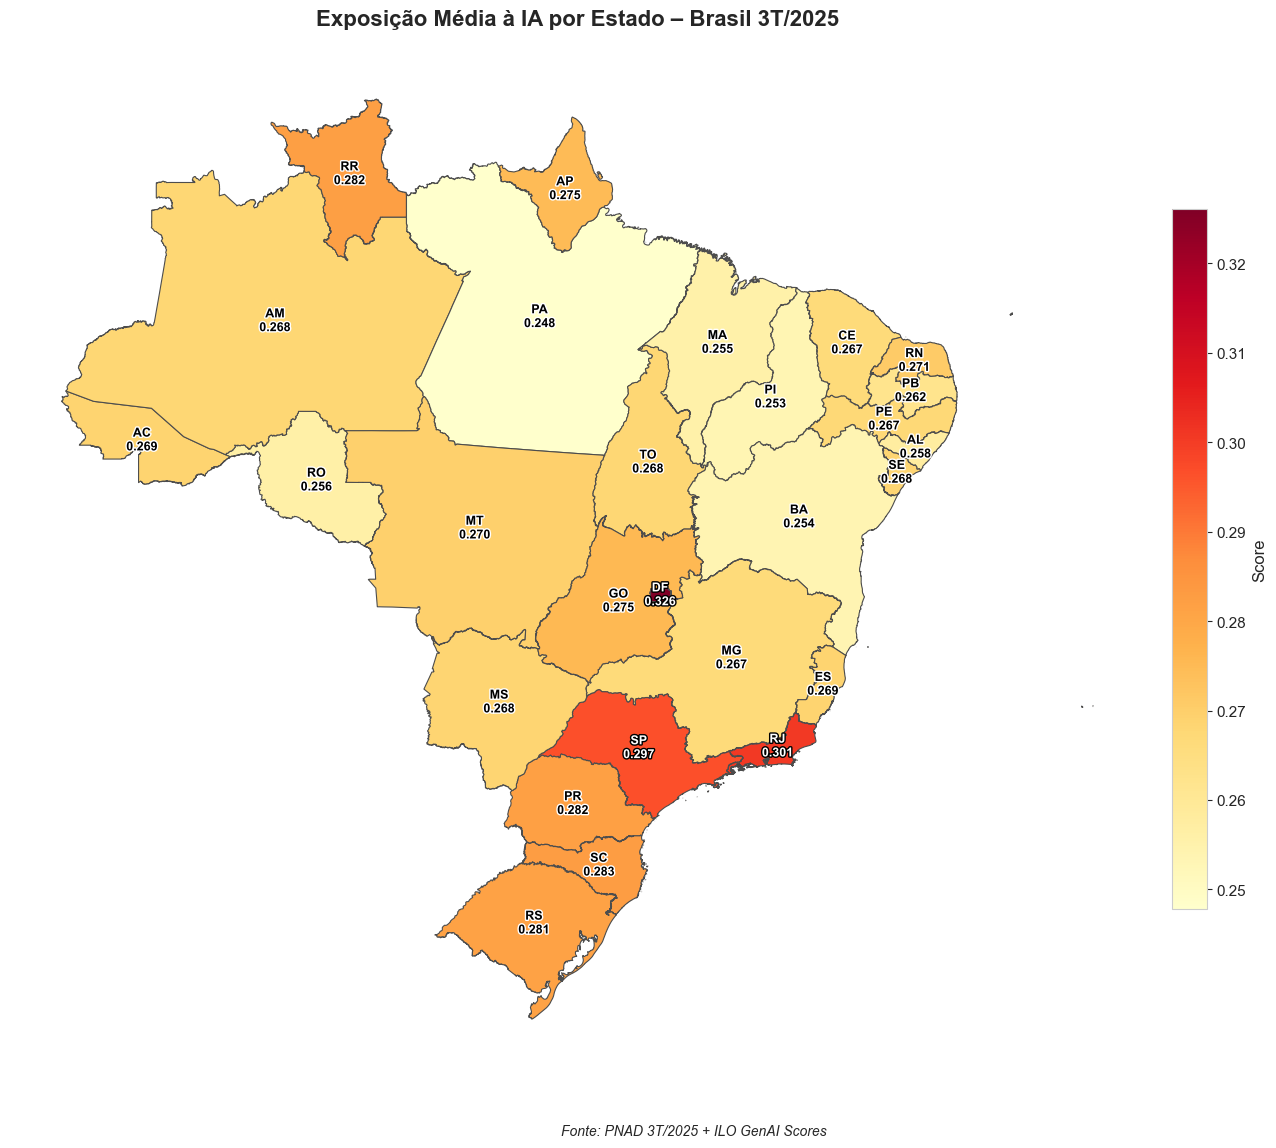

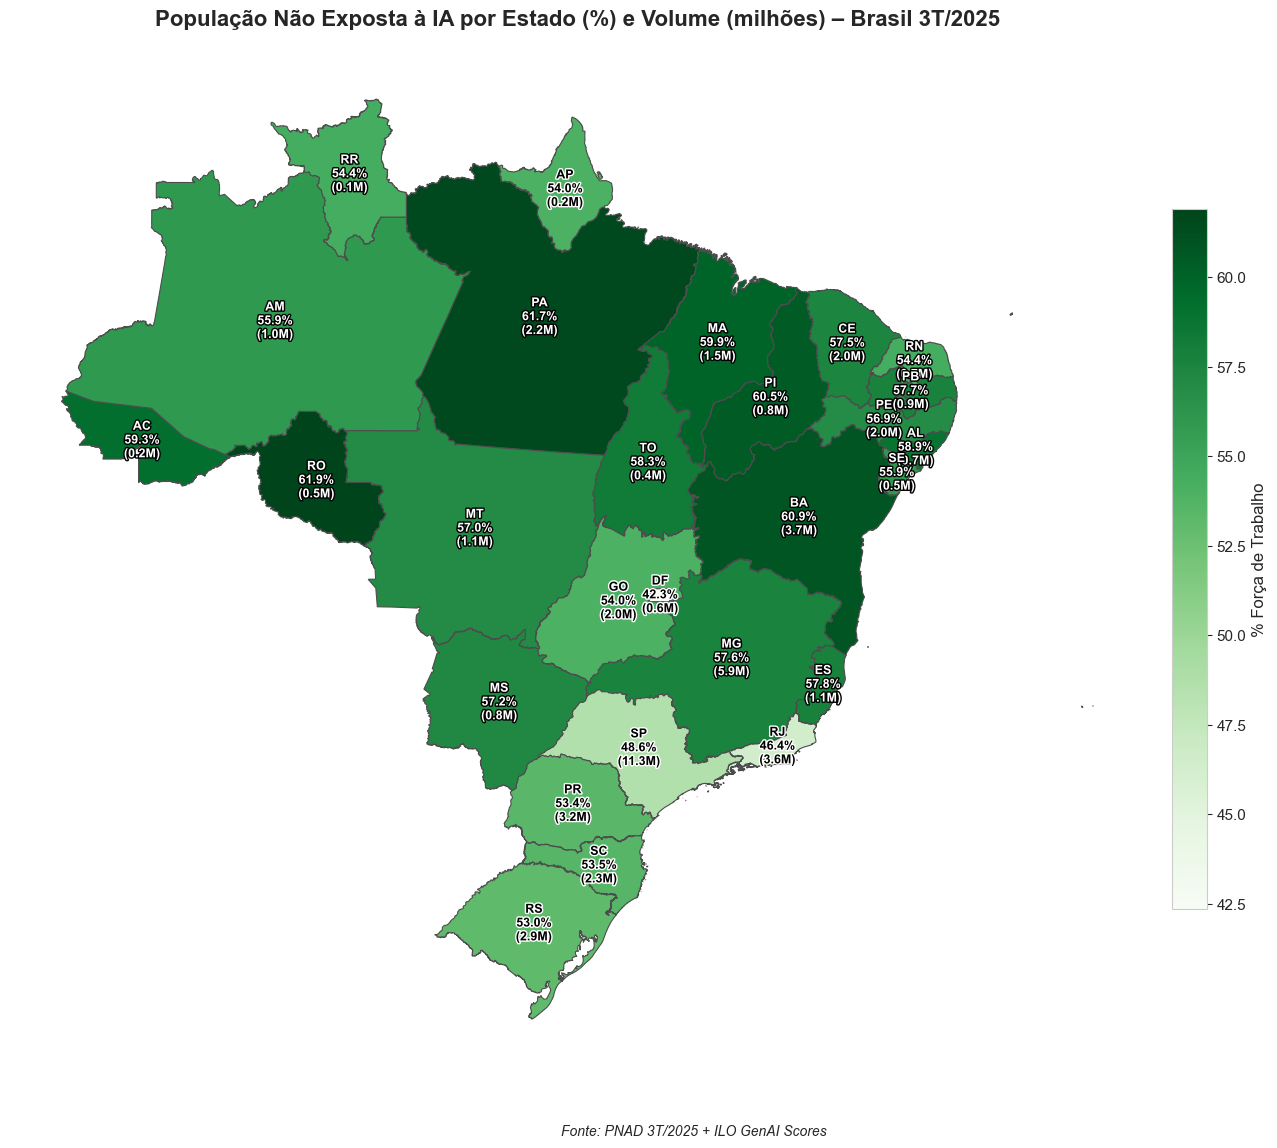

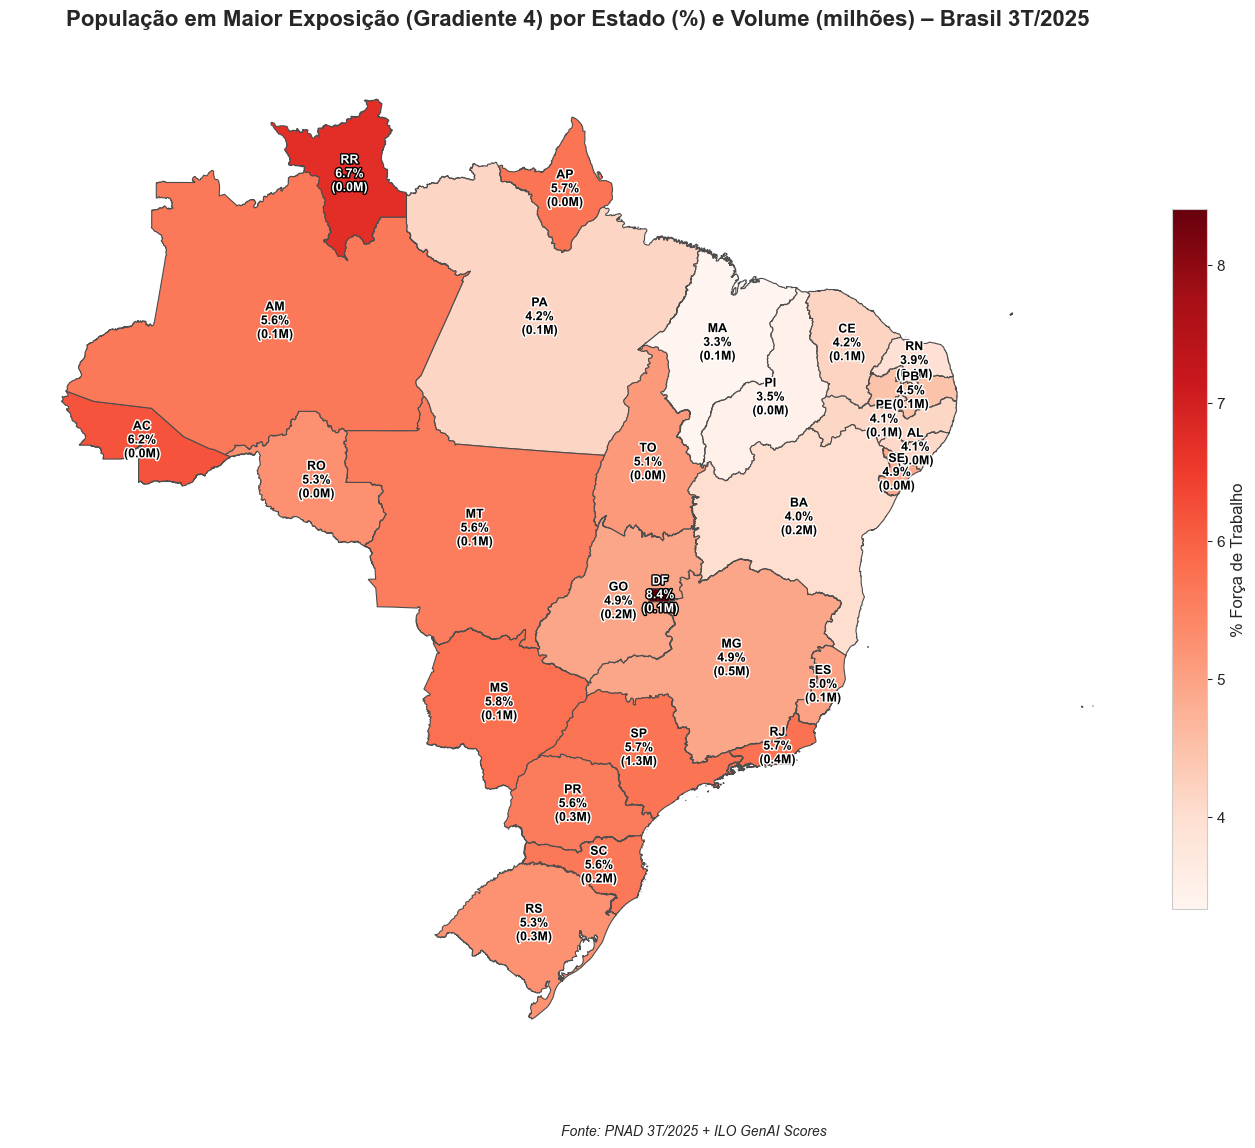

In [76]:
# Etapa 1b.7b - Analise de Dados - Regiao (Mapas)
# Instalar dependencias para mapas (executar apenas uma vez)
%pip install geobr geopandas --quiet

import geobr
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

# ======================================================================
# 7b.1 - Dados geograficos e agregacao por estado
# ======================================================================
# Carregar malha de estados (Brasil)
states_gdf = geobr.read_state(year=2020)
states_gdf['abbrev_state'] = states_gdf['abbrev_state'].str.upper()

# Agregar por sigla_uf (usar df_score ja carregado no notebook)
rows_estado = []
for uf in df_score['sigla_uf'].unique():
    sub = df_score[df_score['sigla_uf'] == uf]
    total = sub['peso'].sum()
    exp_media = weighted_mean(sub['exposure_score'], sub['peso'])
    peso_not = sub[sub['exposure_gradient'] == 'Not Exposed']['peso'].sum()
    peso_g4 = sub[sub['exposure_gradient'] == 'Exposed: Gradient 4']['peso'].sum()
    rows_estado.append({
        'sigla_uf': uf,
        'exposicao_media': exp_media,
        'pct_not_exposed': (peso_not / total * 100) if total > 0 else 0,
        'vol_not_exposed_mil': peso_not / 1e6,
        'pct_grad4': (peso_g4 / total * 100) if total > 0 else 0,
        'vol_grad4_mil': peso_g4 / 1e6,
    })
agg_estado = pd.DataFrame(rows_estado)
gdf = states_gdf.merge(agg_estado, left_on='abbrev_state', right_on='sigla_uf')

# Funcao auxiliar para desenhar um mapa (exibicao no notebook)
def _plot_map(gdf, metric, title, cmap, label_col, fmt='.1f', pct=True, extra_label=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 12))
    ax.set_axis_off()
    vmin, vmax = gdf[metric].min(), gdf[metric].max()
    gdf.plot(column=metric, cmap=cmap, linewidth=0.8, ax=ax,
             edgecolor='0.3', legend=False, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=20, pad=0.02)
    cbar.set_label('% Força de Trabalho' if pct else 'Score', fontsize=12)
    for _, row in gdf.iterrows():
        c = row.geometry.centroid
        v = row[metric]
        vs = f"{v:{fmt}}%" if pct else f"{v:{fmt}}"
        txt = f"{row[label_col]}\n{vs}"
        if extra_label is not None and extra_label in row:
            txt += f"\n({row[extra_label]:.1f}M)"
        nv = (v - vmin) / (vmax - vmin) if vmax > vmin else 0.5
        tc = 'white' if nv > 0.6 else 'black'
        ax.annotate(txt, xy=(c.x, c.y), ha='center', va='center',
                    fontsize=9, fontweight='bold', color=tc,
                    path_effects=[pe.withStroke(linewidth=2, foreground='white' if tc == 'black' else 'black')])
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    fig.text(0.5, 0.02, 'Fonte: PNAD 3T/2025 + ILO GenAI Scores', ha='center', fontsize=10, style='italic')
    plt.tight_layout()
    plt.show()

# ======================================================================
# 7b.2 - Mapa 1: Exposicao media por estado
# ======================================================================
_plot_map(gdf, 'exposicao_media',
          'Exposição Média à IA por Estado – Brasil 3T/2025',
          'YlOrRd', 'abbrev_state', '.3f', pct=False)

# ======================================================================
# 7b.3 - Mapa 2: Gradiente "Nao exposto" e volume por estado
# ======================================================================
_plot_map(gdf, 'pct_not_exposed',
          'População Não Exposta à IA por Estado (%) e Volume (milhões) – Brasil 3T/2025',
          'Greens', 'abbrev_state', '.1f', pct=True, extra_label='vol_not_exposed_mil')

# ======================================================================
# 7b.4 - Mapa 3: Gradiente 4 (maior exposicao) e volume por estado
# ======================================================================
_plot_map(gdf, 'pct_grad4',
          'População em Maior Exposição (Gradiente 4) por Estado (%) e Volume (milhões) – Brasil 3T/2025',
          'Reds', 'abbrev_state', '.1f', pct=True, extra_label='vol_grad4_mil')

### 7d. Indice de Vulnerabilidade Composta
Trabalhadores em situacao de vulnerabilidade composta: alta exposicao + baixa escolaridade + informalidade + baixa renda.

> Este indicador sintetico identifica o grupo mais vulneravel aos impactos
> da IA generativa, combinando multiplas dimensoes de desvantagem.

INDICE DE VULNERABILIDADE COMPOSTA A IA

Trabalhadores em vulnerabilidade composta: 0.06M (0.1%)
(Alta exposicao + Baixa escolaridade + Informalidade + Baixa renda)

Top 10 UFs por % de vulnerabilidade composta:
  PB: 0.2% (0.00M)
  BA: 0.2% (0.01M)
  PI: 0.2% (0.00M)
  AM: 0.1% (0.00M)
  CE: 0.1% (0.00M)
  PE: 0.1% (0.00M)
  SE: 0.1% (0.00M)
  MS: 0.1% (0.00M)
  RO: 0.1% (0.00M)
  MA: 0.1% (0.00M)


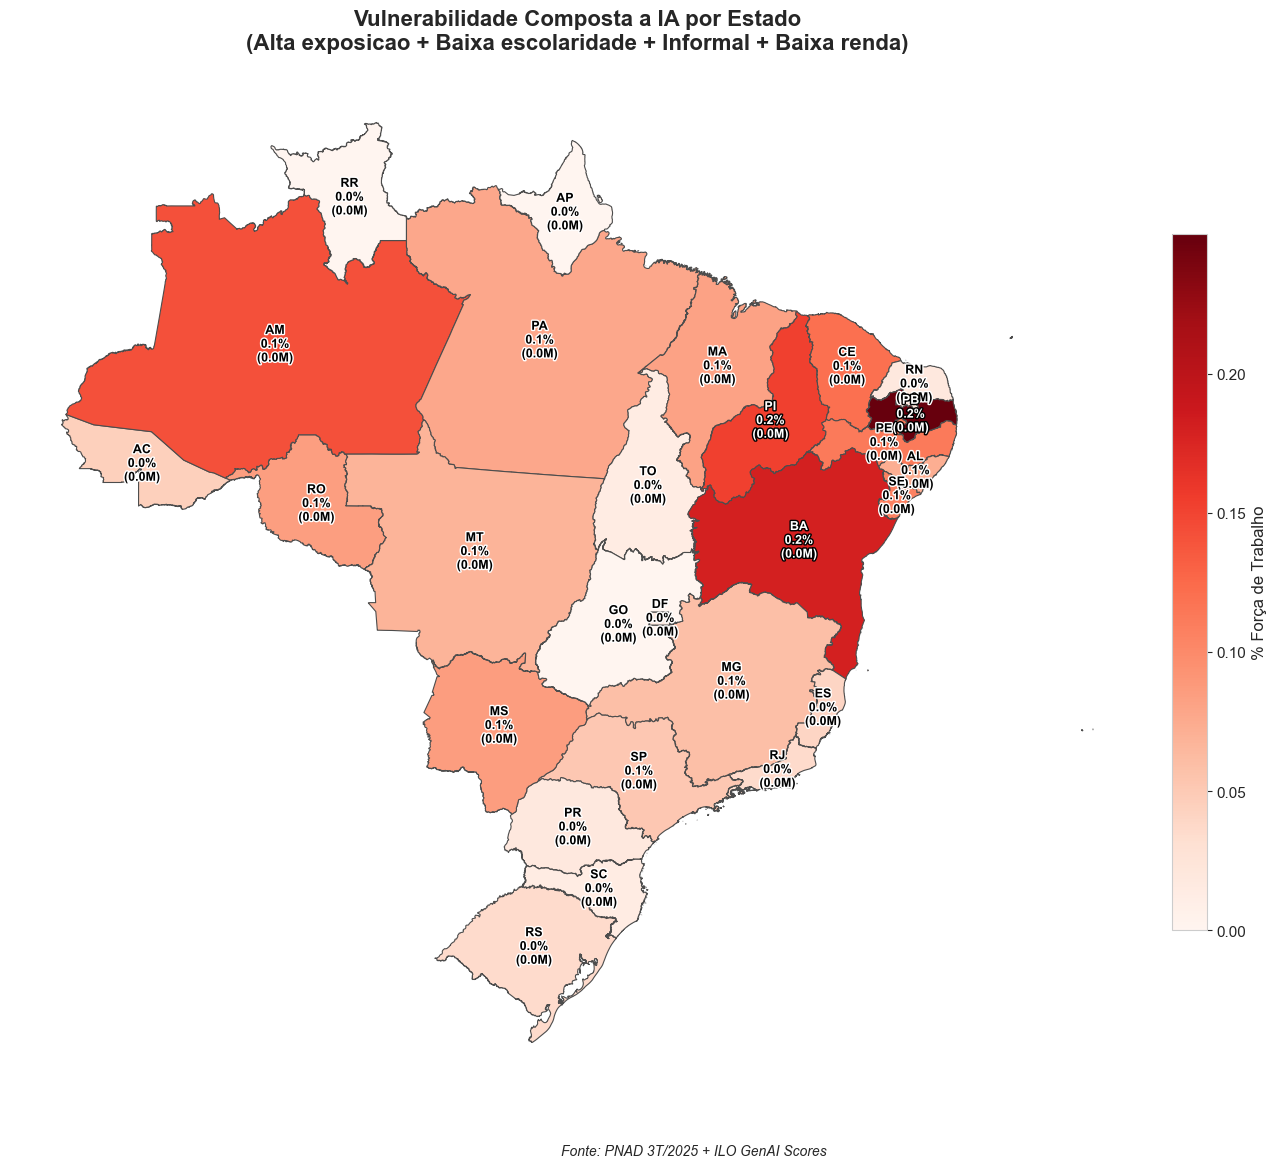

In [77]:
# Etapa 1b.7d - Indice de Vulnerabilidade Composta

# ======================================================================
# 7d - Indice de Vulnerabilidade Composta
# ======================================================================
print("=" * 70)
print("INDICE DE VULNERABILIDADE COMPOSTA A IA")
print("=" * 70)

mediana_renda_vuln = weighted_quantile(df_renda['rendimento_habitual'], df_renda['peso'], 0.5)

df_score['vulneravel'] = (
    df_score['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS) &
    df_score['edu_simples'].isin(['Sem/Fund.Inc.', 'Fund.Comp.']) &
    (df_score['formal'] == 0)
).astype(int)

# Se renda disponivel, adicionar criterio
mask_renda = df_score['tem_renda'] == 1
df_score.loc[mask_renda, 'vulneravel'] = (
    df_score.loc[mask_renda, 'vulneravel'] &
    (df_score.loc[mask_renda, 'rendimento_habitual'] < mediana_renda_vuln)
).astype(int)

pop_vuln = df_score[df_score['vulneravel']==1]['peso'].sum() / 1e6
pct_vuln = pop_vuln / (df_score['peso'].sum()/1e6) * 100

print(f"\nTrabalhadores em vulnerabilidade composta: {pop_vuln:.2f}M ({pct_vuln:.1f}%)")
print("(Alta exposicao + Baixa escolaridade + Informalidade + Baixa renda)")

# Tabela por UF
vuln_uf = df_score.groupby('sigla_uf').apply(lambda g: pd.Series({
    'pct_vulneravel': g[g['vulneravel']==1]['peso'].sum() / g['peso'].sum() * 100 if g['peso'].sum() > 0 else 0,
    'vol_vulneravel': g[g['vulneravel']==1]['peso'].sum() / 1e6,
})).reset_index()

vuln_uf = vuln_uf.sort_values('pct_vulneravel', ascending=False)
print("\nTop 10 UFs por % de vulnerabilidade composta:")
for _, row in vuln_uf.head(10).iterrows():
    print(f"  {row['sigla_uf']}: {row['pct_vulneravel']:.1f}% ({row['vol_vulneravel']:.2f}M)")

# Mapa (se gdf disponivel da secao 7b)
try:
    gdf_vuln = gdf.merge(vuln_uf, left_on='abbrev_state', right_on='sigla_uf')
    _plot_map(gdf_vuln, 'pct_vulneravel',
              'Vulnerabilidade Composta a IA por Estado\n(Alta exposicao + Baixa escolaridade + Informal + Baixa renda)',
              'Reds', 'abbrev_state', fmt='.1f', pct=True, extra_label='vol_vulneravel')
except NameError:
    print("\n  (Mapa nao disponivel - executar secao 7b primeiro)")

### 8. Analise multivariada
Regressoes WLS, equacao de Mincer aumentada e testes de robustez.

**Analises:**
- WLS: Determinantes da exposicao (3 especificacoes com controles progressivos)
- WLS Mincer: log(renda) ~ exposicao + controles (com interacoes)
- Robustez: sensibilidade ao crosswalk (excluir matches 3-digit)

> **Nota metodologica:** Todas as regressoes usam WLS (Weighted Least Squares) com pesos 
> amostrais V1028 e erros-padrao robustos a heterocedasticidade (HC1). 
> Ref: Wooldridge (2020), Cap. 8.

> **Extensão do WP140:** O WP140 trabalha exclusivamente com dados
> agregados por ocupação e não realiza análise no nível individual.
> A equação de Mincer aumentada com o score de exposição como regressor
> é uma extensão metodológica que permite: (1) controlar por
> características individuais (sexo, raça, idade, escolaridade); (2)
> estimar o "prêmio" de exposição na renda condicionando na composição
> da força de trabalho; (3) testar interações (exposição×formalidade,
> exposição×gênero). Essa abordagem segue a sugestão implícita do WP140
> de que pesquisas futuras devem "explore the relationship between
> exposure and labour market outcomes at the individual level" (p. 39).

In [78]:
# Etapa 1b.8 - Analise de Dados - Analise multivariada

# ======================================================================
# 8.1 - WLS: Determinantes da exposicao (3 especificacoes)
# ======================================================================
print("=" * 70)
print("REGRESSAO WLS: DETERMINANTES DA EXPOSICAO A IA")
print("=" * 70)

df_reg = df_score[['exposure_score', 'sexo_texto', 'raca_agregada', 'idade',
                     'nivel_instrucao', 'grande_grupo', 'regiao', 'formal',
                     'setor_agregado', 'peso']].dropna().copy()

print(f"Amostra para regressao: {len(df_reg):,} observacoes")

# Modelo 1: apenas demografia
m1 = smf.wls(
    'exposure_score ~ C(sexo_texto, Treatment("Homem")) + C(raca_agregada, Treatment("Negra")) + '
    'idade + I(idade**2) + C(nivel_instrucao)',
    data=df_reg, weights=df_reg['peso']
).fit(cov_type='HC1')

# Modelo 2: + ocupacao e regiao
m2 = smf.wls(
    'exposure_score ~ C(sexo_texto, Treatment("Homem")) + C(raca_agregada, Treatment("Negra")) + '
    'idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao)',
    data=df_reg, weights=df_reg['peso']
).fit(cov_type='HC1')

# Modelo 3: + setor e formalidade
m3 = smf.wls(
    'exposure_score ~ C(sexo_texto, Treatment("Homem")) + C(raca_agregada, Treatment("Negra")) + '
    'idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao) + '
    'C(setor_agregado) + formal',
    data=df_reg, weights=df_reg['peso']
).fit(cov_type='HC1')

# Tabela comparativa dos 3 modelos
def extract_key_params(model, label):
    """Extrai coeficientes-chave de um modelo."""
    params = {}
    for var in model.params.index:
        coef = model.params[var]
        se = model.bse[var]
        pval = model.pvalues[var]
        params[var] = f"{coef:+.4f} ({se:.4f}){sig_stars(pval)}"
    return params

# Variaveis-chave para reportar
key_vars = [
    ('C(sexo_texto, Treatment("Homem"))[T.Mulher]', 'Mulher (ref: Homem)'),
    ('C(raca_agregada, Treatment("Negra"))[T.Branca]', 'Branca (ref: Negra)'),
    ('idade', 'Idade'),
    ('formal', 'Formal'),
]

print("\n{:<30} {:<25} {:<25} {:<25}".format('Variavel', 'M1 (Demog.)', 'M2 (+Ocup.)', 'M3 (Completo)'))
print("-" * 105)

for var_name, var_label in key_vars:
    vals = []
    for m in [m1, m2, m3]:
        if var_name in m.params.index:
            coef = m.params[var_name]
            pval = m.pvalues[var_name]
            vals.append(f"{coef:+.4f}{sig_stars(pval)}")
        else:
            vals.append("--")
    print(f"{var_label:<30} {vals[0]:<25} {vals[1]:<25} {vals[2]:<25}")

print("-" * 105)
print(f"{'R²':<30} {m1.rsquared:.4f}{'':<20} {m2.rsquared:.4f}{'':<20} {m3.rsquared:.4f}")
print(f"{'N':<30} {int(m1.nobs):,}{'':<20} {int(m2.nobs):,}{'':<20} {int(m3.nobs):,}")
print(f"\nSignificancia: * p<0.05, ** p<0.01, *** p<0.001")

print("\n--- Modelo completo (M3) - Resumo ---")
print(m3.summary().tables[1])

# ======================================================================
# 8.2 - Equacao de Mincer com exposicao
# ======================================================================
print("\n" + "=" * 70)
print("EQUACAO DE MINCER AUMENTADA: log(renda) ~ exposicao + controles")
print("=" * 70)

df_mincer = df_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                        'raca_agregada', 'idade', 'nivel_instrucao', 'formal',
                        'regiao', 'setor_agregado', 'peso']].dropna().copy()
df_mincer['log_renda'] = np.log(df_mincer['rendimento_habitual'].clip(lower=1))

print(f"Amostra Mincer: {len(df_mincer):,} observacoes")

# Mincer 1: exposicao + capital humano basico
mincer1 = smf.wls(
    'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal',
    data=df_mincer, weights=df_mincer['peso']
).fit(cov_type='HC1')

# Mincer 2: + controles regionais e setoriais
mincer2 = smf.wls(
    'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
    data=df_mincer, weights=df_mincer['peso']
).fit(cov_type='HC1')

# Mincer 3: + exposicao quadratica + interacoes
mincer3 = smf.wls(
    'log_renda ~ exposure_score + I(exposure_score**2) + '
    'exposure_score:C(sexo_texto) + exposure_score:formal + '
    'C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
    data=df_mincer, weights=df_mincer['peso']
).fit(cov_type='HC1')

print("\n{:<40} {:<20} {:<20} {:<20}".format('Variavel', 'Mincer 1', 'Mincer 2', 'Mincer 3'))
print("-" * 100)

mincer_vars = [
    ('exposure_score', 'Exposicao'),
    ('I(exposure_score ** 2)', 'Exposicao²'),
    ('exposure_score:C(sexo_texto)[T.Mulher]', 'Exposicao x Mulher'),
    ('exposure_score:formal', 'Exposicao x Formal'),
    ('C(sexo_texto)[T.Mulher]', 'Mulher'),
    ('formal', 'Formal'),
]

for var_name, var_label in mincer_vars:
    vals = []
    for m in [mincer1, mincer2, mincer3]:
        if var_name in m.params.index:
            coef = m.params[var_name]
            pval = m.pvalues[var_name]
            vals.append(f"{coef:+.4f}{sig_stars(pval)}")
        else:
            vals.append("--")
    print(f"{var_label:<40} {vals[0]:<20} {vals[1]:<20} {vals[2]:<20}")

print("-" * 100)
print(f"{'R²':<40} {mincer1.rsquared:.4f}{'':<15} {mincer2.rsquared:.4f}{'':<15} {mincer3.rsquared:.4f}")
print(f"{'N':<40} {int(mincer1.nobs):,}{'':<15} {int(mincer2.nobs):,}{'':<15} {int(mincer3.nobs):,}")

# Interpretacao
coef_exp = mincer2.params['exposure_score']
pval_exp = mincer2.pvalues['exposure_score']
print(f"\nInterpretacao (Mincer 2):")
print(f"  Coeficiente de exposicao: {coef_exp:+.4f} {sig_stars(pval_exp)}")
if coef_exp > 0:
    pct_effect = (np.exp(coef_exp) - 1) * 100
    print(f"  Um aumento de 0.1 no score de exposicao esta associado a")
    print(f"  {pct_effect/10:.1f}% de aumento na renda, ceteris paribus.")
else:
    print(f"  Exposicao nao apresenta associacao significativa com renda")
    print(f"  apos controlar por ocupacao, setor e outras caracteristicas.")

print("\n  ATENCAO: Esta analise e cross-sectional e nao permite")
print("  inferencia causal. A correlacao entre exposicao e renda")
print("  reflete sorting ocupacional, nao efeito causal da IA.")

# ======================================================================
# 8.3 - Robustez: sensibilidade ao crosswalk
# ======================================================================
print("\n" + "=" * 70)
print("ANALISE DE ROBUSTEZ: SENSIBILIDADE AO CROSSWALK")
print("=" * 70)

# Amostra restrita: apenas matches 4-digit
df_4d = df_score[df_score['match_level'] == '4-digit'].copy()
df_4d_renda = df_4d[(df_4d['tem_renda'] == 1)].copy()

mean_full, ci_lo_f, ci_hi_f = weighted_ci(df_score['exposure_score'], df_score['peso'])
mean_4d, ci_lo_4, ci_hi_4 = weighted_ci(df_4d['exposure_score'], df_4d['peso'])

print(f"\n  Amostra completa:    N={len(df_score):,} | Media={mean_full:.4f} [IC: {ci_lo_f:.4f}-{ci_hi_f:.4f}]")
print(f"  Apenas match 4-digit: N={len(df_4d):,} | Media={mean_4d:.4f} [IC: {ci_lo_4:.4f}-{ci_hi_4:.4f}]")
print(f"  Diferenca: {mean_full - mean_4d:+.4f}")

# Re-rodar Mincer 2 com amostra restrita
df_mincer_4d = df_4d_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                              'raca_agregada', 'idade', 'nivel_instrucao', 'formal',
                              'regiao', 'setor_agregado', 'peso']].dropna().copy()
df_mincer_4d['log_renda'] = np.log(df_mincer_4d['rendimento_habitual'].clip(lower=1))

if len(df_mincer_4d) > 100:
    mincer_4d = smf.wls(
        'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
        'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
        data=df_mincer_4d, weights=df_mincer_4d['peso']
    ).fit(cov_type='HC1')

    coef_full = mincer2.params['exposure_score']
    coef_4d = mincer_4d.params['exposure_score']
    print(f"\n  Coef. exposicao (amostra completa): {coef_full:+.4f}{sig_stars(mincer2.pvalues['exposure_score'])}")
    print(f"  Coef. exposicao (apenas 4-digit):   {coef_4d:+.4f}{sig_stars(mincer_4d.pvalues['exposure_score'])}")
    print(f"  Diferenca: {abs(coef_full - coef_4d):.4f}")

    if abs(coef_full - coef_4d) < 0.05:
        print("\n  CONCLUSAO: Resultados robustos a exclusao dos matches 3-digit.")
    else:
        print("\n  ATENCAO: Sensibilidade detectada ao crosswalk. Reportar ambos.")
else:
    print("\n  Amostra 4-digit insuficiente para regressao.")

# ======================================================================
# 8.4 - Robustez 2: Winzorizacao da renda (P1-P99)
# ======================================================================
print("\n" + "=" * 70)
print("ROBUSTEZ 2: WINZORIZACAO DA RENDA (P1-P99)")
print("=" * 70)

p1 = df_mincer['rendimento_habitual'].quantile(0.01)
p99 = df_mincer['rendimento_habitual'].quantile(0.99)
df_winsor = df_mincer.copy()
df_winsor['renda_winsor'] = df_winsor['rendimento_habitual'].clip(lower=p1, upper=p99)
df_winsor['log_renda_w'] = np.log(df_winsor['renda_winsor'].clip(lower=1))

mincer_winsor = smf.wls(
    'log_renda_w ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
    data=df_winsor, weights=df_winsor['peso']
).fit(cov_type='HC1')

coef_orig = mincer2.params['exposure_score']
coef_winsor = mincer_winsor.params['exposure_score']
print(f"  Coef. exposicao (original):     {coef_orig:+.4f}")
print(f"  Coef. exposicao (winsorizado):  {coef_winsor:+.4f}")
print(f"  Diferenca: {abs(coef_orig - coef_winsor):.4f}")

if abs(coef_orig - coef_winsor) < 0.05:
    print("\n  CONCLUSAO: Resultados robustos a winzorizacao da renda.")
else:
    print("\n  ATENCAO: Sensibilidade detectada. Reportar ambos os resultados.")

# ======================================================================
# 8.5 - Robustez 3: Cluster por UPA (se disponivel)
# ======================================================================
print("\n" + "=" * 70)
print("ROBUSTEZ 3: ERROS-PADRAO CLUSTERIZADOS POR UPA")
print("=" * 70)

if 'upa' in df_mincer.columns or 'UPA' in df_mincer.columns:
    upa_col = 'upa' if 'upa' in df_mincer.columns else 'UPA'
    mincer_cluster = smf.wls(
        'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
        'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
        data=df_mincer, weights=df_mincer['peso']
    ).fit(cov_type='cluster', cov_kwds={'groups': df_mincer[upa_col]})

    print(f"\n  SE (HC1):    {mincer2.bse['exposure_score']:.4f}")
    print(f"  SE (Cluster): {mincer_cluster.bse['exposure_score']:.4f}")
    print(f"  Razao: {mincer_cluster.bse['exposure_score']/mincer2.bse['exposure_score']:.2f}x")

    if mincer_cluster.bse['exposure_score'] > mincer2.bse['exposure_score'] * 1.5:
        print("\n  ATENCAO: SEs clusterizados substancialmente maiores.")
        print("  HC1 subestima incerteza. Reportar ambos.")
    else:
        print("\n  SEs clusterizados similares aos HC1. Resultados robustos.")
else:
    print("\n  \u26a0 Variavel UPA nao encontrada no dataframe.")
    print("  Adicionar na etapa 1a (preparacao de dados) para permitir")
    print("  clusterizacao dos erros-padrao.")

REGRESSAO WLS: DETERMINANTES DA EXPOSICAO A IA
Amostra para regressao: 206,230 observacoes

Variavel                       M1 (Demog.)               M2 (+Ocup.)               M3 (Completo)            
---------------------------------------------------------------------------------------------------------
Mulher (ref: Homem)            +0.0215***                -0.0098***                +0.0008                  
Branca (ref: Negra)            +0.0207***                +0.0114***                +0.0076***               
Idade                          -0.0056***                -0.0015***                -0.0010***               
Formal                         --                        --                        +0.0024***               
---------------------------------------------------------------------------------------------------------
R²                             0.2255                     0.6832                     0.7430
N                              206,230                     

### 9. Sintese e conclusoes

Resumo dos principais achados, comparacao com a literatura e limitacoes.

> **Limitações adicionais identificadas:**
> 7. Crosswalk COD→ISCO-08 introduz erro de medida; o índice ILO foi
>    construído para ISCO-08 e a conversão pode gerar mismatches
>    (teste de robustez com matches 4-digit mitiga parcialmente)
> 8. O índice ILO reflete a capacidade tecnológica de 2024/2025;
>    a rápida evolução da IA generativa pode torná-lo defasado
> 9. Erros-padrão tratam amostra como SRS; valores reais podem ser
>    maiores com desenho amostral complexo

> **Posicionamento do Brasil no contexto global (WP140):**
> O Brasil se posiciona como caso típico de país de renda média-alta:
> exposição média (0.278) ligeiramente inferior à média global (0.30)
> e consistente com o grupo upper-middle-income (~0.29). A proporção de
> trabalhadores em alta exposição (10.1%) está abaixo de países de alta
> renda (~20%) mas acima de países de baixa renda (~5%). As extensões
> originais desta dissertação — raça, formalidade, análise regional e
> equação de Mincer — preenchem lacunas deixadas pelo WP140 para o
> contexto de países em desenvolvimento.

In [79]:
# Etapa 1b.9 - Sintese e conclusoes

print("=" * 70)
print("SINTESE DOS PRINCIPAIS ACHADOS")
print("=" * 70)

print(f"""
ETAPA 1 - Analise Descritiva da Exposicao a IA Generativa no Brasil
=====================================================================
Dados: PNADc Q3/{PNAD_ANO} | {len(df):,} observacoes | {df['peso'].sum()/1e6:.1f} milhoes de trabalhadores
Indice: ILO WP140 (Gmyrek, Berg & Cappelli, 2025) | 427 ocupacoes ISCO-08

1. PERFIL DA EXPOSICAO
   - Exposicao media: {mean_geral:.3f} [IC 95%: {ci_lo_geral:.3f}-{ci_hi_geral:.3f}]
   - Inferior a media global (0.30), refletindo estrutura ocupacional brasileira
   - {pct_alta:.1f}% da forca de trabalho em alta exposicao (Gradientes 3-4)
   - Gini da exposicao: {gini_exp:.3f} (desigualdade moderada)

2. DESIGUALDADE E RENDA
   - Trabalhadores mais expostos ganham mais (razao Q5/Q1 = {renda_q5/renda_q1:.2f}x)
   - ATENCAO: relacao nao-monotonica (Q4 > Q5 em renda)
   - Relacao exposicao-renda nao-linear (LOWESS revela curvatura)
   - Indice de concentracao: {conc_index:+.4f} (exposicao concentrada nos mais ricos)
   - Regressao quantilica sugere efeito heterogeneo ao longo da distribuicao

3. GENERO E RACA
   - Mulheres mais expostas que homens ({gap_sexo:+.3f}, p<0.001)
   - Brancos mais expostos que negros ({gap_raca:+.3f}, p<0.001)
   - Oaxaca-Blinder: gaps explicados principalmente por segregacao ocupacional

4. FORMALIDADE
   - Formais mais expostos que informais (gap significativo)
   - Interacao exposicao x formalidade: retorno MENOR para formais
   - Informais de alta exposicao capturam mais retorno (profissionais liberais)

5. SETOR E OCUPACAO
   - Setores criticos: Financas, TI, Servicos Profissionais
   - Apoio administrativo e mais exposto dos grandes grupos
   - ANOVA confirma: setor e ocupacao explicam maior parte da variancia

6. REGIAO
   - Sudeste lidera, Norte menor exposicao
   - Variacao regional modesta (R² baixo na ANOVA por regiao)

7. ANALISE MULTIVARIADA
   - WLS: sexo, escolaridade e ocupacao sao os principais preditores
   - Mincer: exposicao associada positivamente a renda (ceteris paribus)
   - Robustez: resultados estaveis excluindo matches 3-digit

LIMITACOES
----------
1. Analise cross-sectional (Q3/{PNAD_ANO}) - nao permite inferencia causal
2. Indice global (OIT) aplicado ao Brasil - pode nao capturar especificidades locais
3. Exposicao != impacto - mede potencial, nao efeito realizado
4. Erros-padrao podem ser subestimados (amostra tratada como SRS)
5. 0.8% das observacoes sem match no crosswalk COD-ISCO08
6. Variavel de renda ausente para ~1.1 milhao de trabalhadores
7. Crosswalk COD->ISCO-08 introduz erro de medida; teste com matches 4-digit mitiga parcialmente
8. Indice ILO reflete capacidade tecnologica de 2024/2025; pode estar defasado
9. Erros-padrao tratam amostra como SRS; valores reais podem ser maiores
""")

print("=" * 70)
print("FIM DA ETAPA 1b - ANALISE DESCRITIVA")
print("=" * 70)

SINTESE DOS PRINCIPAIS ACHADOS

ETAPA 1 - Analise Descritiva da Exposicao a IA Generativa no Brasil
Dados: PNADc Q3/2025 | 207,901 observacoes | 97.8 milhoes de trabalhadores
Indice: ILO WP140 (Gmyrek, Berg & Cappelli, 2025) | 427 ocupacoes ISCO-08

1. PERFIL DA EXPOSICAO
   - Exposicao media: 0.278 [IC 95%: 0.278-0.278]
   - Inferior a media global (0.30), refletindo estrutura ocupacional brasileira
   - 10.1% da forca de trabalho em alta exposicao (Gradientes 3-4)
   - Gini da exposicao: 0.295 (desigualdade moderada)

2. DESIGUALDADE E RENDA
   - Trabalhadores mais expostos ganham mais (razao Q5/Q1 = 2.23x)
   - ATENCAO: relacao nao-monotonica (Q4 > Q5 em renda)
   - Relacao exposicao-renda nao-linear (LOWESS revela curvatura)
   - Indice de concentracao: +0.0810 (exposicao concentrada nos mais ricos)
   - Regressao quantilica sugere efeito heterogeneo ao longo da distribuicao

3. GENERO E RACA
   - Mulheres mais expostas que homens (+0.044, p<0.001)
   - Brancos mais expostos que ne